In [1]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import os
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import sys

import scanpy as sc
import matplotlib.pyplot as plt

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
options(future.globals.maxSize = 1000000 * 1024^2)
set.seed(2422012)

# Single cell libraries
library(Seurat)
library(sctransform)
library(rliger)
library(SeuratWrappers)
library(conos)
library(scater)
library(scDblFinder)
library(scran)
library(sctransform)
library(scry)

# Rest libraries
library(BiocParallel)
library(ggplot2)
library(dplyr)
library(cowplot)

library(scCustomize)




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [3]:
projectdir = "C:/Users/kyria.000/Documents/PhD/Projects/Feng2023/"
datadir = projectdir + "Data/"
resultdir = projectdir + "Result/"
adata_file = 'AnnData_Integrated.h5ad'


In [4]:
adata= sc.read_h5ad(resultdir+adata_file) 
adata.X = adata.layers["soupX_counts"]

In [5]:
%%R -i adata -i adata.obs 
set.seed(2422012)
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")

KeyboardInterrupt: 

In [6]:
%%R -i adata.var_names
DEM_sort_genes <- as.data.frame(seurat_obj@assays$RNA@counts)[sort(rownames(seurat_obj),decreasing=F),]
DEM_sort_genes[1:3,1:3]

         AAACCCAAGGTACATA-1-0 AAACCCACACAAGTGG-1-0 AAACCCAGTATAGGAT-1-0
A1BG                        0                    0                    0
A1BG-AS1                    0                    0                    0
A2M                         0                    1                    2


In [7]:
%%R -i adata.obs
set.seed(2422012)
seurat_obj = CreateSeuratObject(DEM_sort_genes,meta.data=adata.obs, min.cells = 3, min.features = 200)
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)


In [8]:
%%R
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat_obj), 10)
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat_obj)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)


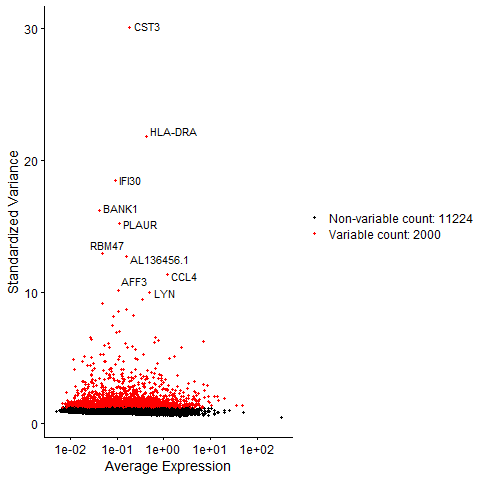

In [9]:
%%R
plot2

In [10]:
%%R
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

In [11]:
%%R
seurat_obj <- RunPCA(seurat_obj, verbose = FALSE)
seurat_obj <- RunUMAP(seurat_obj, reduction = "pca", dims = 1:30)
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:30)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5)


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34792
Number of edges: 1196944

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9082
Number of communities: 17
Elapsed time: 5 seconds


In [12]:
%%R
colnames(seurat_obj@meta.data)


 [1] "orig.ident"                 "nCount_RNA"                
 [3] "nFeature_RNA"               "n_genes"                   
 [5] "scDblFinder_class"          "n_genes_by_counts"         
 [7] "log1p_n_genes_by_counts"    "total_counts"              
 [9] "log1p_total_counts"         "pct_counts_in_top_20_genes"
[11] "Condition"                  "CellType"                  
[13] "batch"                      "total_counts_mt"           
[15] "log1p_total_counts_mt"      "pct_counts_mt"             
[17] "total_counts_ribo"          "log1p_total_counts_ribo"   
[19] "pct_counts_ribo"            "total_counts_hb"           
[21] "log1p_total_counts_hb"      "pct_counts_hb"             
[23] "mt_outlier"                 "leiden"                    
[25] "louvain"                    "mito_leiden"               
[27] "RNA_snn_res.0.5"            "seurat_clusters"           


In [13]:
%%R
seurat_obj$sct_clusters <- seurat_obj$RNA_snn_res.0.5

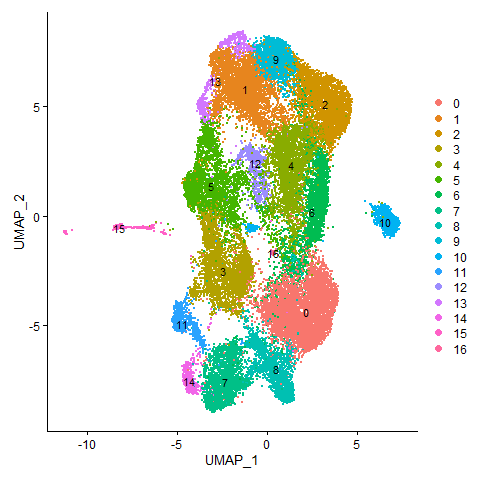

In [14]:
%%R
DimPlot(seurat_obj, reduction = "umap",label=T)


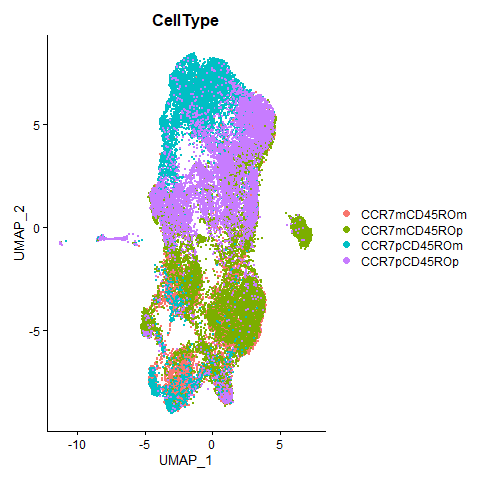

In [15]:
%%R
DimPlot(seurat_obj,group.by="CellType", reduction = "umap",pt.size=0.0001)

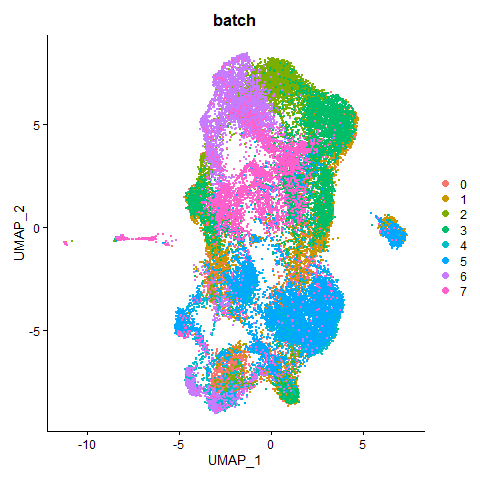

In [16]:
%%R
DimPlot(seurat_obj,group.by="batch", reduction = "umap",pt.size=0.0001)

## SCT MAPPING

In [17]:
%%R
set.seed(2422012)
SCT.list <- SplitObject(seurat_obj, split.by = "Condition")
SCT.list <- lapply(X = SCT.list, FUN = SCTransform,vst.flavor = "v2")
features <- SelectIntegrationFeatures(object.list = SCT.list, nfeatures = 3000)
SCT.list <- PrepSCTIntegration(object.list = SCT.list, anchor.features = features)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~11s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=18s  


In [18]:
%%R
set.seed(2422012)
SCT.anchors <- FindIntegrationAnchors(object.list = SCT.list, normalization.method = "SCT",
    anchor.features = features)
SCT.combined <- IntegrateData(anchorset = SCT.anchors, normalization.method = "SCT")


  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=14m 35s


In [19]:
%%R
SCT.combined <- RunPCA(SCT.combined, verbose = FALSE)
SCT.combined <- RunUMAP(SCT.combined, reduction = "pca", dims = 1:30)
SCT.combined <- FindNeighbors(SCT.combined, reduction = "pca", dims = 1:30)
SCT.combined <- FindClusters(SCT.combined, resolution = 0.5)
SCT.combined$sct_int_clusters <- SCT.combined$integrated_snn_res.0.5

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34792
Number of edges: 1269681

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8875
Number of communities: 13
Elapsed time: 6 seconds


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34792
Number of edges: 1269681

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8619
Number of communities: 21
Elapsed time: 6 seconds


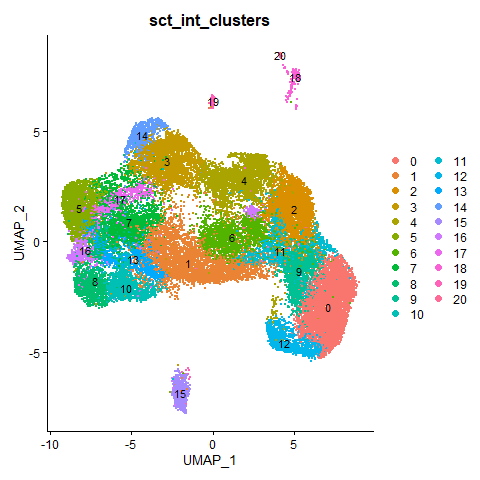

In [124]:
%%R
DefaultAssay(SCT.combined) <- "integrated"
SCT.combined <- FindClusters(SCT.combined, resolution = 0.8)
SCT.combined$sct_int_clusters <- SCT.combined$integrated_snn_res.0.8
DimPlot(SCT.combined , reduction = "umap", group.by = "sct_int_clusters",label=T)

In [28]:
%%R
library(dittoSeq)
p1 <- dittoBarPlot(SCT.combined , "Condition", 
    group.by = "sct_int_clusters",
    color.panel =c("#F8766D","#078992")
)+ theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
p2 <- dittoBarPlot(SCT.combined , "CCellType", 
    group.by = "sct_int_clusters",
    color.panel =c("#F8766D","#7CAE00","#00BFC4","#C77CFF")
)+ggtitle("")

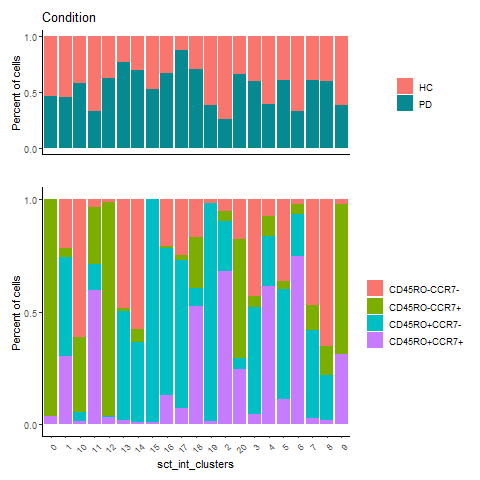

In [29]:
%%R
p1/p2+ plot_layout(heights = c(1,2))

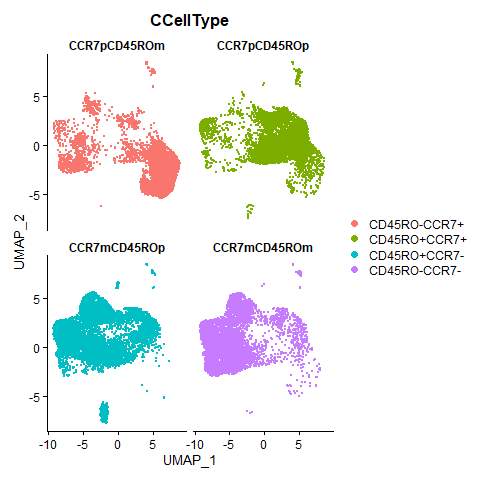

In [30]:
%%R
DimPlot(SCT.combined , reduction = "umap", group.by = "CCellType",split.by="CellType",ncol=2)

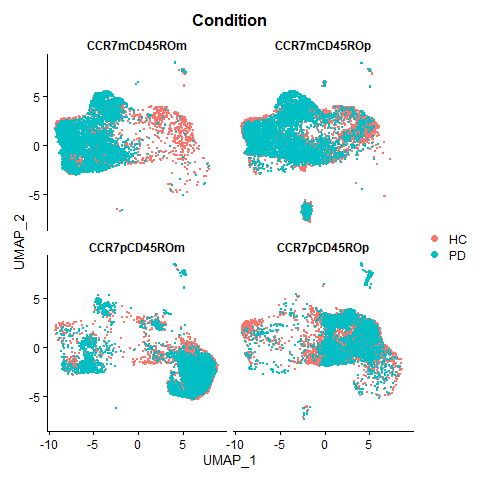

In [22]:
%%R
DimPlot(SCT.combined , reduction = "umap", group.by = "Condition", split.by = "CellType",ncol=2)

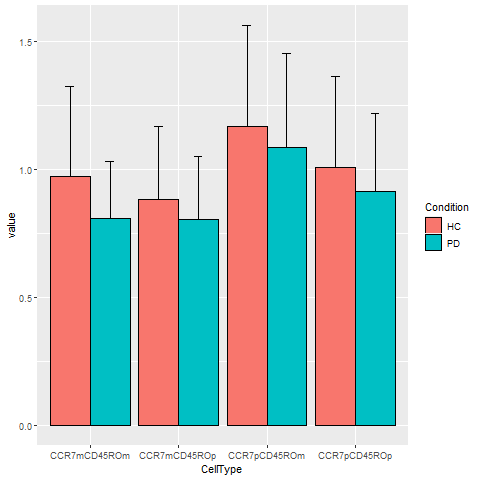

In [23]:
%%R
library(stringr)
# the SCT.combined is your seurat SCT.combined
data.df <- SCT.combined@meta.data[, c("CellType", "Condition","sct_int_clusters")]
data.df["value"] <- SCT.combined$SCT@data["CCR7", ]
# "CCR7","PTPRC"
data.df <- data.df %>% mutate(group = paste(CellType, Condition, sep=":"))

# remove cells that do not express the gene
data.df <- data.df %>% filter(value > 0)

data.df.2 <- data.df %>% group_by(group) %>% summarise(sd=sd(value),value=mean(value))
X <- str_split(data.df.2$'group', ":", 2, simplify=TRUE)
data.df.2$'CellType' <- X[, 1]
data.df.2$'Condition' <- X[, 2]

ggplot(data.df.2, aes(fill=Condition, y=value, x=CellType)) + 
    geom_bar(color="black", position="dodge", stat="identity") +
    geom_errorbar(
        aes(ymin=value, ymax=value+sd), width=.2,
        position=position_dodge(.9)
    )

In [24]:
%%R
SCT.combined

An object of class Seurat 
29448 features across 34792 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap


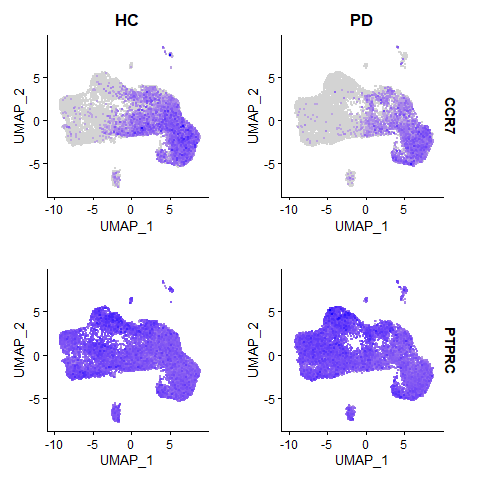

In [153]:
%%R
DefaultAssay(SCT.combined) <- "SCT"
FeaturePlot(SCT.combined , features = c("CCR7","PTPRC"),
, split.by = "Condition",pt.size=0,order=TRUE)


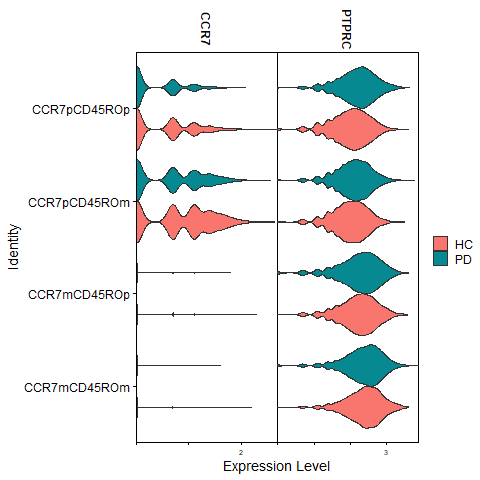

In [154]:
%%R
DefaultAssay(SCT.combined) <- "SCT"
SCT.combined <- SetIdent(SCT.combined , value = "CellType")
VlnPlot(SCT.combined , features = c("CCR7","PTPRC"),stack=T, split.by = "Condition",pt.size=0)

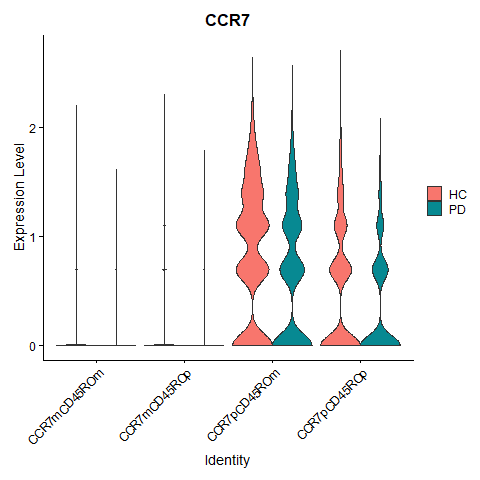

In [25]:
%%R
DefaultAssay(SCT.combined) <- "SCT"
SCT.combined <- SetIdent(SCT.combined , value = "CellType")
VlnPlot(SCT.combined , features = "CCR7", split.by = "Condition",pt.size=0)


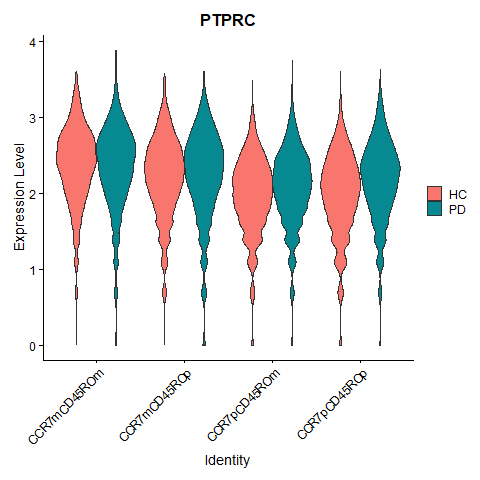

In [26]:
%%R
DefaultAssay(SCT.combined) <- "SCT"
SCT.combined <- SetIdent(SCT.combined , value = "CellType")
VlnPlot(SCT.combined , features = "PTPRC", split.by = "Condition",pt.size=0)

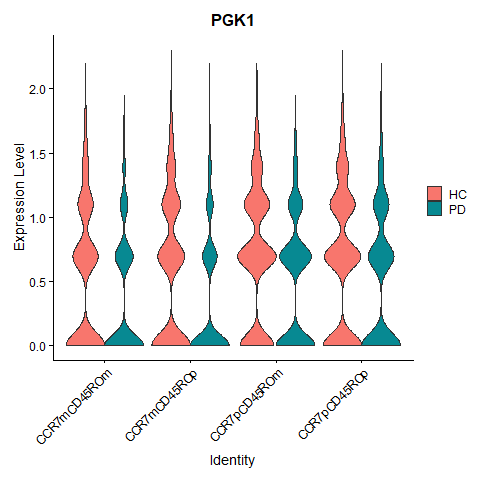

In [73]:
%%R
DefaultAssay(SCT.combined) <- "SCT"
SCT.combined <- SetIdent(SCT.combined , value = "CellType")
VlnPlot(SCT.combined , features = "PGK1", split.by = "Condition",pt.size=0)

In [6]:
%%R
DefaultAssay(SCT.combined) <- "integrated"
SCT.combined <- FindClusters(SCT.combined, resolution = 0.8)
SCT.combined$sct_int_clusters <- SCT.combined$integrated_snn_res.0.8
DefaultAssay(SCT.combined) <- "SCT"

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34792
Number of edges: 1269681

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8619
Number of communities: 21
Elapsed time: 6 seconds


In [5]:
%%R
DefaultAssay(SCT.combined) <- "SCT"
SCT.combined<- SetIdent(SCT.combined , value = "sct_int_clusters")
SCT.combined <- PrepSCTFindMarkers(SCT.combined)

In [7]:
%%R -i resultdir
saveRDS(SCT.combined,paste0(resultdir,"Seuraobject.rds"))

## LOAD OOBJECT

## LOAD OOBJECT

In [12]:
%%R -i resultdir
SCT.combined <- readRDS(paste0(resultdir,"Seuraobject.rds"))



In [16]:
%%R
SCT.combined$CCellType <-  SCT.combined$CellType
SCT.combined$CCellType[SCT.combined$CellType == "CCR7mCD45ROm"] <- "CD45RO-CCR7-"
SCT.combined$CCellType[SCT.combined$CellType == "CCR7pCD45ROp"] <- "CD45RO+CCR7+"
SCT.combined$CCellType[SCT.combined$CellType == "CCR7pCD45ROm"] <- "CD45RO-CCR7+"
SCT.combined$CCellType[SCT.combined$CellType == "CCR7mCD45ROp"] <- "CD45RO+CCR7-"
SCT.combined$CellType <- factor(SCT.combined$CellType ,levels=c("CCR7pCD45ROm", "CCR7pCD45ROp", "CCR7mCD45ROp", "CCR7mCD45ROm")) 
SCT.combined$CCellType <- factor(SCT.combined$CCellType ,levels=c("CD45RO-CCR7+", "CD45RO+CCR7+", "CD45RO+CCR7-", "CD45RO-CCR7-")) 

In [21]:
%%R
Idents(SCT.combined) <- "CCellType"
cluster_stats <- Cluster_Stats_All_Samples(seurat_object = SCT.combined , group_by_var = "Condition")
readr::write_csv(cluster_stats,"Before_CCR7_filtering_CellType_stats.csv")
print(cluster_stats)

SCT.combined$Combined <- paste0(SCT.combined$Condition,": " ,SCT.combined$CCellType )
median_stats <- Median_Stats(seurat_object = SCT.combined , group_by_var = "Combined")
readr::write_csv(median_stats,"Before_CCR7_filtering_Median_stats.csv")

print(median_stats)

      Cluster Number      Freq    HC    PD      HC_%      PD_%
 CD45RO-CCR7+   8867  25.48574  4493  4374  25.67575  25.29347
 CD45RO+CCR7+   8675  24.93389  5558  3117  31.76181  18.02463
 CD45RO+CCR7-   9669  27.79087  4075  5594  23.28704  32.34835
 CD45RO-CCR7-   7581  21.78949  3373  4208  19.27539  24.33355
        Total  34792 100.00000 17499 17293 100.00000 100.00000
# A tibble: 9 x 3
  Combined           Median_nCount_RNA Median_nFeature_RNA
  <chr>                          <dbl>               <dbl>
1 HC: CD45RO+CCR7+               5152                2309 
2 HC: CD45RO+CCR7-               4868                2260 
3 HC: CD45RO-CCR7+               5912                2542 
4 HC: CD45RO-CCR7-               5401                2448 
5 PD: CD45RO+CCR7+               5477                2379 
6 PD: CD45RO+CCR7-               3704.               1864 
7 PD: CD45RO-CCR7+               5570.               2512.
8 PD: CD45RO-CCR7-               4778                2175 
9 Totals (All 

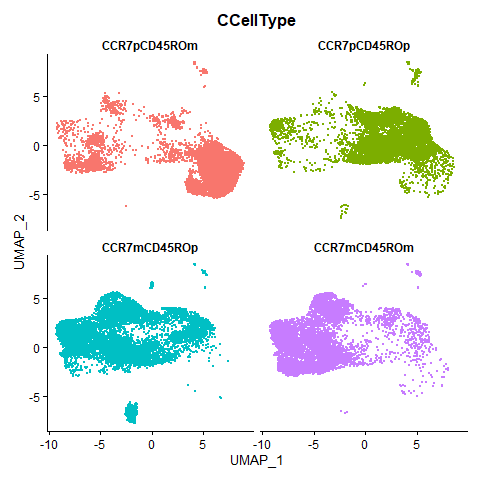

In [8]:
%%R 
DimPlot(SCT.combined , reduction = "umap", group.by = "CCellType",split.by="CellType",ncol=2)+NoLegend()

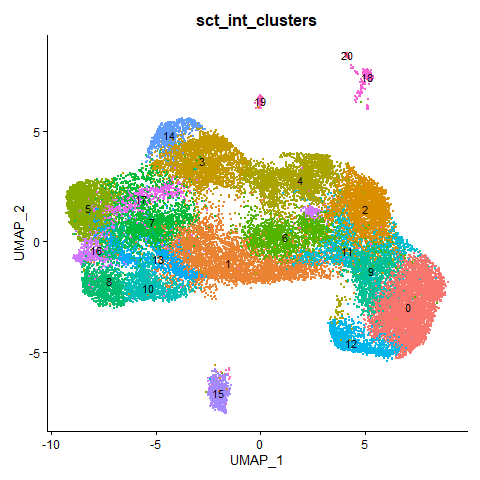

In [9]:
%%R 
DimPlot(SCT.combined , reduction = "umap", group.by = "sct_int_clusters",label=T)+NoLegend()

In [10]:
%%R 
unique(SCT.combined$CellType)

[1] 4 3 1 2


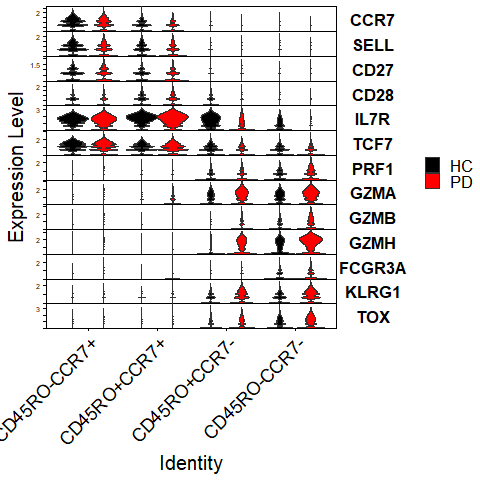

In [11]:
%%R 
DefaultAssay(SCT.combined) <- "SCT"
SCT.combined <- SetIdent(SCT.combined , value = "CCellType")
vlnplot_known_markers <- VlnPlot(SCT.combined,  flip = TRUE , features = c("CCR7", "SELL", "CD27", "CD28","IL7R","TCF7", "PRF1", "GZMA", "GZMB", "GZMH", "FCGR3A" ,  "KLRG1",  "TOX"),cols=c("black","red"),stack=T, split.by = "Condition",pt.size=0)+
    theme(text = element_text(size = 20),axis.text = element_text(size = 18))

ggsave(plot=vlnplot_known_markers,
    filename=paste0(resultdir,"Vlnplot_known_markers.pdf"),
    dpi = 600,
    width=12,
    height=12)

vlnplot_known_markers


In [12]:
%%R
# ================= CCR7 Possitive ================================
Idents(SCT.combined) <- "CellType"
CCR7pCD45ROp_ALL_cells.use <- WhichCells(SCT.combined,idents = "CCR7pCD45ROp")
CCR7pCD45ROp_ALL <- subset(SCT.combined, cells = CCR7pCD45ROp_ALL_cells.use)
Idents(CCR7pCD45ROp_ALL) <- "Condition"
CCR7pCD45ROp_ALL_HC <- subset(CCR7pCD45ROp_ALL, idents = "HC")
CCR7pCD45ROp_ALL_PD <- subset(CCR7pCD45ROp_ALL, idents = "PD")

CCR7pCD45ROm_ALL_cells.use <- WhichCells(SCT.combined,idents = "CCR7pCD45ROm")
CCR7pCD45ROm_ALL <- subset(SCT.combined, cells = CCR7pCD45ROm_ALL_cells.use)
Idents(CCR7pCD45ROm_ALL) <- "Condition"
CCR7pCD45ROm_ALL_HC <- subset(CCR7pCD45ROm_ALL, idents = "HC")
CCR7pCD45ROm_ALL_PD <- subset(CCR7pCD45ROm_ALL, idents = "PD")

# ================= CCR7 Negative ================================
CCR7mCD45ROp_ALL_cells.use <- WhichCells(SCT.combined,idents = "CCR7mCD45ROp")
CCR7mCD45ROp_ALL<- subset(SCT.combined, cells = CCR7mCD45ROp_ALL_cells.use)
Idents(CCR7mCD45ROp_ALL) <- "Condition"
CCR7mCD45ROp_ALL_HC <- subset(CCR7mCD45ROp_ALL, idents = "HC")
CCR7mCD45ROp_ALL_PD <- subset(CCR7mCD45ROp_ALL, idents = "PD")

CCR7mCD45ROm_ALL_cells.use <- WhichCells(SCT.combined,idents = "CCR7mCD45ROm")
CCR7mCD45ROm_ALL<- subset(SCT.combined, cells = CCR7mCD45ROm_ALL_cells.use)
Idents(CCR7mCD45ROm_ALL) <- "Condition"
CCR7mCD45ROm_ALL_HC <- subset(CCR7mCD45ROm_ALL, idents = "HC")
CCR7mCD45ROm_ALL_PD <- subset(CCR7mCD45ROm_ALL, idents = "PD")

## Density Plots

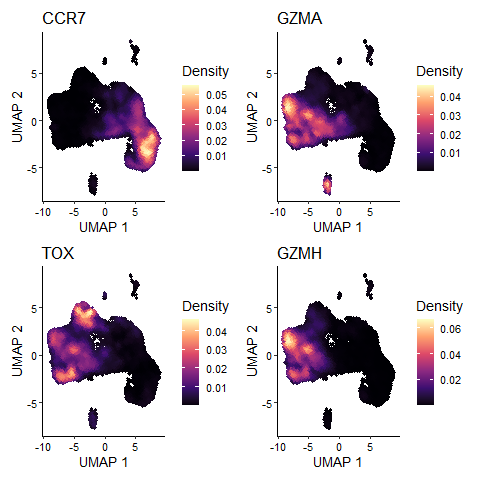

In [13]:
%%R
library(scCustomize)
p1 <- Plot_Density_Custom(seurat_object = SCT.combined, features = c("CCR7","GZMA"))
p2 <-Plot_Density_Custom(seurat_object = SCT.combined, features = c("TOX","GZMH"))
p1/p2

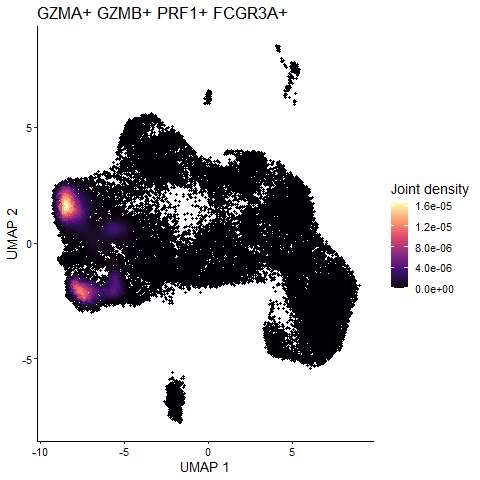

In [14]:
%%R
Plot_Density_Joint_Only(seurat_object =  SCT.combined, features = c("GZMA", "GZMB","PRF1","FCGR3A"))


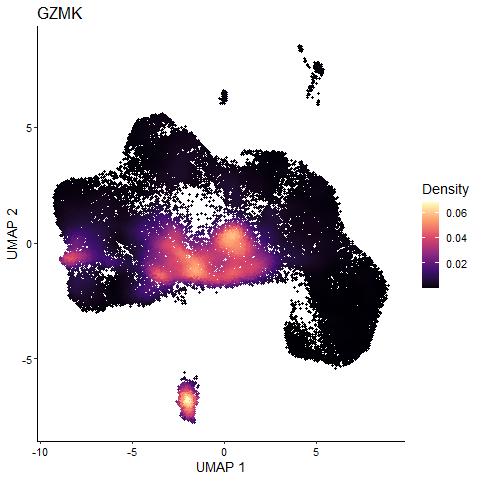

In [15]:
%%R
Plot_Density_Custom(seurat_object = SCT.combined, features = c("GZMK"))

[[1]]

[[2]]

[[3]]

[[4]]



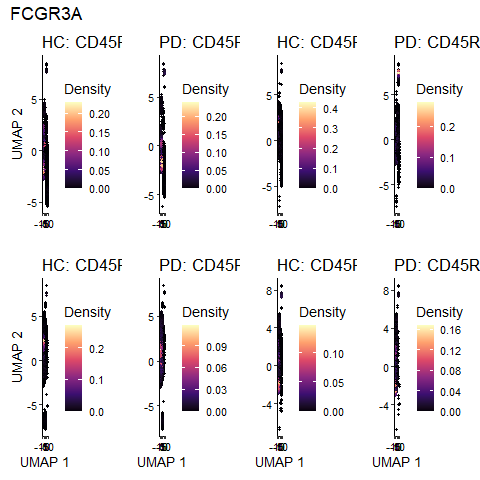

In [16]:
%%R
individual_features = c("GZMA","GZMB","PRF1","FCGR3A")
lapply(individual_features,FUN=function(i_feature){
    p11 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROm_ALL_HC, features = i_feature)+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
    p12 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROm_ALL_PD, features = i_feature)+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

    p21 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROp_ALL_HC, features = i_feature)+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
    p22 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROp_ALL_PD, features = i_feature)+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

    p31 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROp_ALL_HC, features = i_feature)+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
    p32 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROp_ALL_PD, features = i_feature)+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

    p41 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROm_ALL_HC, features = i_feature)+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
    p42 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROm_ALL_PD, features = i_feature)+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

    p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
        plot_layout(ncol = 4)+ 
        plot_annotation(title = i_feature, theme = theme(plot.title = element_text(size = 18)))

    ggsave(plot=p_all,filename=paste0(resultdir,"Density_",i_feature,".png"),width=15,height=8,dpi = 600)
    p_all
})


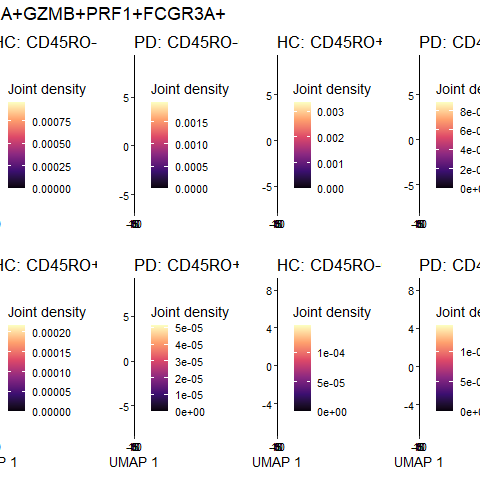

In [17]:
%%R
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_ALL_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_ALL_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_ALL_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_ALL_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_ALL_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_ALL_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_ALL_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_ALL_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMA+GZMB+PRF1+FCGR3A+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Density_GZMA+GZMB+PRF1+FCGR3A+.png"),width=15,height=8,dpi = 600)
p_all

# Possitive Percentages

In [18]:
%%R
percent_express <- Percent_Expressing(seurat_object = SCT.combined,
    assay="RNA",
    features = c("CCR7","GZMA"),
    group_by = "CellType")
df_percent <- as.data.frame(percent_express)
df_percent_melt <- as.data.frame(reshape2::melt(as.matrix(df_percent)))
df_percent_melt
df_percent_melt$CellType <- as.vector(df_percent_melt$Var2)
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7mCD45ROm"] <- "CD45RO-CCR7-"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7pCD45ROp"] <- "CD45RO+CCR7+"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7pCD45ROm"] <- "CD45RO-CCR7+"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7mCD45ROp"] <- "CD45RO+CCR7-"
df_percent_melt$CellType <- factor(df_percent_melt$CellType ,levels=c("CD45RO-CCR7+", "CD45RO+CCR7+", "CD45RO+CCR7-", "CD45RO-CCR7-")) 



In [19]:
%%R
df_percent_melt


  Var1         Var2     value     CellType
1 CCR7 CCR7pCD45ROm 67.384685 CD45RO-CCR7+
2 GZMA CCR7pCD45ROm 13.657381 CD45RO-CCR7+
3 CCR7 CCR7pCD45ROp 48.195965 CD45RO+CCR7+
4 GZMA CCR7pCD45ROp 23.469741 CD45RO+CCR7+
5 CCR7 CCR7mCD45ROp  6.919020 CD45RO+CCR7-
6 GZMA CCR7mCD45ROp 58.061847 CD45RO+CCR7-
7 CCR7 CCR7mCD45ROm  4.379369 CD45RO-CCR7-
8 GZMA CCR7mCD45ROm 63.883393 CD45RO-CCR7-


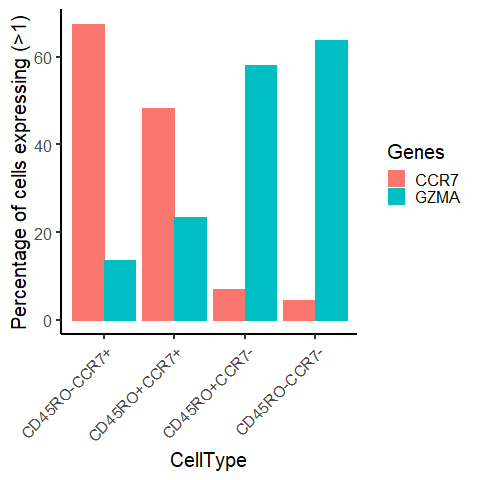

In [20]:
%%R
colnames(df_percent_melt)[1] <- "Genes"
ggplot(df_percent_melt,aes(x=CellType,y=value,color=Genes,fill=Genes))+
    geom_bar(stat="identity",, position=position_dodge())+
    ylab("Percentage of cells expressing (>1)")+
    xlab("CellType")+
    theme_classic(base_size = 20)+RotatedAxis()


# SUBSETTING BASED ON CCR7

In [4]:
%%R
Subbbb <- readRDS("Subset_raarranged.rds")
grep('CCR7', rownames(SCT.combined@assays$RNA@counts))
CCR7_matrix <-SCT.combined@assays$RNA@counts[rownames(SCT.combined@assays$RNA@counts)[2965], ]


SCT.combined

Idents(SCT.combined) <- "CellType"
DefaultAssay(SCT.combined) <- "RNA"


# ================= CCR7 Possitive ================================
Idents(SCT.combined) <- "CellType"
CCR7pCD45ROp_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7pCD45ROp", expression = CCR7>= 1 )
CCR7pCD45ROp_T <- subset(SCT.combined, cells = CCR7pCD45ROp_T_cells.use)
Idents(CCR7pCD45ROp_T) <- "Condition"
CCR7pCD45ROp_T_HC <- subset(CCR7pCD45ROp_T, idents = "HC")
CCR7pCD45ROp_T_PD <- subset(CCR7pCD45ROp_T, idents = "PD")

CCR7pCD45ROm_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7pCD45ROm", expression = CCR7>= 1 )
CCR7pCD45ROm_T <- subset(SCT.combined, cells = CCR7pCD45ROm_T_cells.use)
Idents(CCR7pCD45ROm_T) <- "Condition"
CCR7pCD45ROm_T_HC <- subset(CCR7pCD45ROm_T, idents = "HC")
CCR7pCD45ROm_T_PD <- subset(CCR7pCD45ROm_T, idents = "PD")

# ================= CCR7 Negative ================================
CCR7mCD45ROp_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7mCD45ROp", expression = CCR7<= 0 )
CCR7mCD45ROp_T<- subset(SCT.combined, cells = CCR7mCD45ROp_T_cells.use)
Idents(CCR7mCD45ROp_T) <- "Condition"
CCR7mCD45ROp_T_HC <- subset(CCR7mCD45ROp_T, idents = "HC")
CCR7mCD45ROp_T_PD <- subset(CCR7mCD45ROp_T, idents = "PD")

CCR7mCD45ROm_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7mCD45ROm", expression = CCR7<= 0 )
CCR7mCD45ROm_T<- subset(SCT.combined, cells = CCR7mCD45ROm_T_cells.use)
Idents(CCR7mCD45ROm_T) <- "Condition"
CCR7mCD45ROm_T_HC <- subset(CCR7mCD45ROm_T, idents = "HC")
CCR7mCD45ROm_T_PD <- subset(CCR7mCD45ROm_T, idents = "PD")




Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'grep': error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'SCT.combined' not found


RInterpreterError: Failed to parse and evaluate line 'Subbbb <- readRDS("Subset_raarranged.rds")\ngrep(\'CCR7\', rownames(SCT.combined@assays$RNA@counts))\nCCR7_matrix <-SCT.combined@assays$RNA@counts[rownames(SCT.combined@assays$RNA@counts)[2965], ]\n\n\nSCT.combined\n\nIdents(SCT.combined) <- "CellType"\nDefaultAssay(SCT.combined) <- "RNA"\n\n\n# ================= CCR7 Possitive ================================\nIdents(SCT.combined) <- "CellType"\nCCR7pCD45ROp_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7pCD45ROp", expression = CCR7>= 1 )\nCCR7pCD45ROp_T <- subset(SCT.combined, cells = CCR7pCD45ROp_T_cells.use)\nIdents(CCR7pCD45ROp_T) <- "Condition"\nCCR7pCD45ROp_T_HC <- subset(CCR7pCD45ROp_T, idents = "HC")\nCCR7pCD45ROp_T_PD <- subset(CCR7pCD45ROp_T, idents = "PD")\n\nCCR7pCD45ROm_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7pCD45ROm", expression = CCR7>= 1 )\nCCR7pCD45ROm_T <- subset(SCT.combined, cells = CCR7pCD45ROm_T_cells.use)\nIdents(CCR7pCD45ROm_T) <- "Condition"\nCCR7pCD45ROm_T_HC <- subset(CCR7pCD45ROm_T, idents = "HC")\nCCR7pCD45ROm_T_PD <- subset(CCR7pCD45ROm_T, idents = "PD")\n\n# ================= CCR7 Negative ================================\nCCR7mCD45ROp_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7mCD45ROp", expression = CCR7<= 0 )\nCCR7mCD45ROp_T<- subset(SCT.combined, cells = CCR7mCD45ROp_T_cells.use)\nIdents(CCR7mCD45ROp_T) <- "Condition"\nCCR7mCD45ROp_T_HC <- subset(CCR7mCD45ROp_T, idents = "HC")\nCCR7mCD45ROp_T_PD <- subset(CCR7mCD45ROp_T, idents = "PD")\n\nCCR7mCD45ROm_T_cells.use <- WhichCells(SCT.combined,idents = "CCR7mCD45ROm", expression = CCR7<= 0 )\nCCR7mCD45ROm_T<- subset(SCT.combined, cells = CCR7mCD45ROm_T_cells.use)\nIdents(CCR7mCD45ROm_T) <- "Condition"\nCCR7mCD45ROm_T_HC <- subset(CCR7mCD45ROm_T, idents = "HC")\nCCR7mCD45ROm_T_PD <- subset(CCR7mCD45ROm_T, idents = "PD")\n\n'.
R error message: "Error in h(simpleError(msg, call)) : \n  error in evaluating the argument 'x' in selecting a method for function 'grep': error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'SCT.combined' not found"

In [22]:
%%R
Sub.combined <- merge(CCR7pCD45ROp_T, y = c(CCR7pCD45ROm_T,CCR7mCD45ROm_T,CCR7mCD45ROp_T))
SCT.list <- SplitObject(Sub.combined , split.by = "Condition")
SCT.list <- lapply(X = SCT.list, FUN = SCTransform,vst.flavor = "v2")
features <- SelectIntegrationFeatures(object.list = SCT.list, nfeatures = 3000)
SCT.list <- PrepSCTIntegration(object.list = SCT.list, anchor.features = features)



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  


In [23]:
%%R
set.seed(2422012)
SCT.anchors <- FindIntegrationAnchors(object.list = SCT.list, normalization.method = "SCT",
    anchor.features = features)
Subbbb<- IntegrateData(anchorset = SCT.anchors, normalization.method = "SCT")


  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06m 32s


# RECALCUATE SPACE

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 24832
Number of edges: 915692

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8754
Number of communities: 12
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 24832
Number of edges: 915692

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8474
Number of communities: 19
Elapsed time: 3 seconds


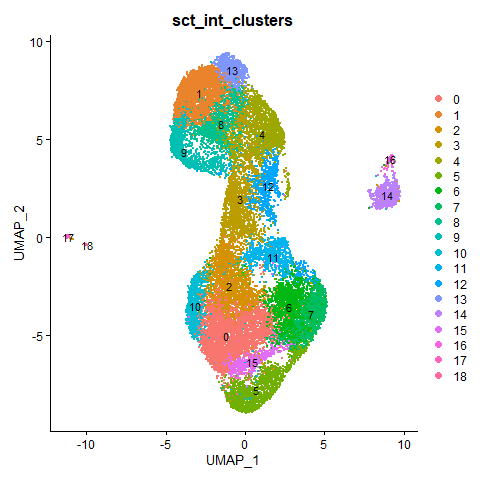

In [24]:
%%R
DefaultAssay(Subbbb) <- "integrated"
Subbbb <- RunPCA(Subbbb, verbose = FALSE)
Subbbb <- RunUMAP(Subbbb, reduction = "pca", dims = 1:30)
Subbbb <- FindNeighbors(Subbbb, reduction = "pca", dims = 1:30)
Subbbb <- FindClusters(Subbbb, resolution = 0.5)
Subbbb$sct_int_clusters <- Subbbb$integrated_snn_res.0.5
Subbbb <- FindClusters(Subbbb, resolution = 0.8)
Subbbb$sct_int_clusters <- Subbbb$integrated_snn_res.0.8
DimPlot(Subbbb , reduction = "umap", group.by = "sct_int_clusters",label=T)

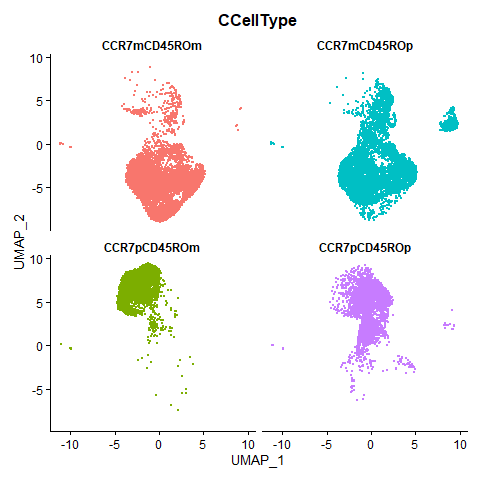

In [25]:
%%R 
DimPlot(Subbbb , reduction = "umap", group.by = "CCellType",split.by="CellType",ncol=2)+NoLegend()

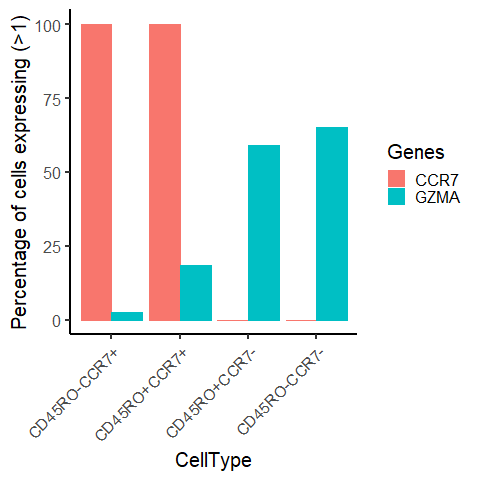

In [26]:
%%R
DefaultAssay(Subbbb) <- "RNA"

percent_express <- Percent_Expressing(seurat_object = Subbbb,
    assay="SCT",slot="counts",
    features = c("CCR7","GZMA"),
    threshold = 0,
    group_by = "CellType")
df_percent <- as.data.frame(percent_express)
df_percent_melt <- as.data.frame(reshape2::melt(as.matrix(df_percent)))
df_percent_melt
df_percent_melt$CellType <- as.vector(df_percent_melt$Var2)
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7mCD45ROm"] <- "CD45RO-CCR7-"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7pCD45ROp"] <- "CD45RO+CCR7+"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7pCD45ROm"] <- "CD45RO-CCR7+"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7mCD45ROp"] <- "CD45RO+CCR7-"
df_percent_melt$CellType <- factor(df_percent_melt$CellType ,levels=c("CD45RO-CCR7+", "CD45RO+CCR7+", "CD45RO+CCR7-", "CD45RO-CCR7-")) 
colnames(df_percent_melt)[1] <- "Genes"
ggplot(df_percent_melt,aes(x=CellType,y=value,color=Genes,fill=Genes))+
    geom_bar(stat="identity",, position=position_dodge())+
    ylab("Percentage of cells expressing (>1)")+
    xlab("CellType")+
    theme_classic(base_size = 20)+RotatedAxis()

In [27]:
%%R
unique(Subbbb@assays$RNA@counts["CCR7",Subbbb$CellType=="CCR7pCD45ROp"])

 [1]  1  3  2  5  4  7  6  9 10  8 36 11 16 13


In [28]:
%%R
percent_express

     CCR7pCD45ROp CCR7pCD45ROm CCR7mCD45ROm CCR7mCD45ROp
CCR7    100.00000    100.00000      0.00000      0.00000
GZMA     18.48467      2.56459     65.30104     59.03251


In [5]:
%%R
Subbbb <- readRDS("Subset_raarranged.rds")
Idents(Subbbb) <- "CellType"
DefaultAssay(Subbbb) <- "RNA"


# ================= CCR7 Possitive ================================
Idents(Subbbb) <- "CellType"
CCR7pCD45ROp_T_cells.use <- WhichCells(Subbbb,idents = "CCR7pCD45ROp", expression = CCR7>= 1 )
CCR7pCD45ROp_T <- subset(Subbbb, cells = CCR7pCD45ROp_T_cells.use)
Idents(CCR7pCD45ROp_T) <- "Condition"
CCR7pCD45ROp_T_HC <- subset(CCR7pCD45ROp_T, idents = "HC")
CCR7pCD45ROp_T_PD <- subset(CCR7pCD45ROp_T, idents = "PD")

CCR7pCD45ROm_T_cells.use <- WhichCells(Subbbb,idents = "CCR7pCD45ROm", expression = CCR7>= 1 )
CCR7pCD45ROm_T <- subset(Subbbb, cells = CCR7pCD45ROm_T_cells.use)
Idents(CCR7pCD45ROm_T) <- "Condition"
CCR7pCD45ROm_T_HC <- subset(CCR7pCD45ROm_T, idents = "HC")
CCR7pCD45ROm_T_PD <- subset(CCR7pCD45ROm_T, idents = "PD")

# ================= CCR7 Negative ================================
CCR7mCD45ROp_T_cells.use <- WhichCells(Subbbb,idents = "CCR7mCD45ROp", expression = CCR7<= 0 )
CCR7mCD45ROp_T<- subset(Subbbb, cells = CCR7mCD45ROp_T_cells.use)
Idents(CCR7mCD45ROp_T) <- "Condition"
CCR7mCD45ROp_T_HC <- subset(CCR7mCD45ROp_T, idents = "HC")
CCR7mCD45ROp_T_PD <- subset(CCR7mCD45ROp_T, idents = "PD")

CCR7mCD45ROm_T_cells.use <- WhichCells(Subbbb,idents = "CCR7mCD45ROm", expression = CCR7<= 0 )
CCR7mCD45ROm_T<- subset(Subbbb, cells = CCR7mCD45ROm_T_cells.use)
Idents(CCR7mCD45ROm_T) <- "Condition"
CCR7mCD45ROm_T_HC <- subset(CCR7mCD45ROm_T, idents = "HC")
CCR7mCD45ROm_T_PD <- subset(CCR7mCD45ROm_T, idents = "PD")

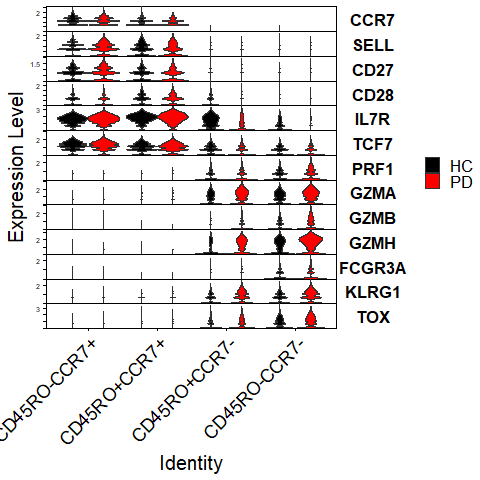

In [ ]:
%%R -i resultdir
DefaultAssay(Subbbb) <- "SCT"
Subbbb <- SetIdent(Subbbb , value = "CCellType")
vlnplot_known_markers <- VlnPlot(Subbbb,  flip = TRUE , 
    features = c("CCR7", "SELL", "CD27", "CD28","IL7R","TCF7", "PRF1", "GZMA", "GZMB", "GZMH", "FCGR3A" ,"KLRG1",  "TOX"),
    stack=T, split.by = "Condition",pt.size=0,
    cols=c("black","red"))+
    theme(text = element_text(size = 20),axis.text = element_text(size = 18))
ggsave(plot=vlnplot_known_markers,filename=paste0(resultdir,"Subset_vlnplot_known_markers.png"),width=10,height=8,dpi = 600)
ggsave(plot=vlnplot_known_markers,filename=paste0(resultdir,"Subset_vlnplot_known_markers.pdf"),width=10,height=8,dpi = 600)

vlnplot_known_markers

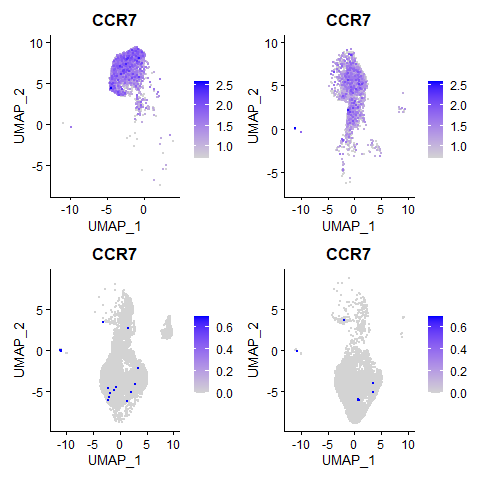

In [7]:
%%R
Subbbb$Combined <- paste0(Subbbb$Condition,Subbbb$CellType,sep="_")
DefaultAssay(Subbbb) <- "SCT"
p1<- FeaturePlot(Subbbb ,keep.scale=NULL ,cells=CCR7pCD45ROm_T_cells.use, features = c("CCR7"),pt.size=0,order=TRUE,min.cutoff = 0)
p2<- FeaturePlot(Subbbb ,keep.scale=NULL ,cells=CCR7pCD45ROp_T_cells.use, features = c("CCR7"),pt.size=0,order=TRUE,min.cutoff = 0)
p3<- FeaturePlot(Subbbb ,keep.scale=NULL ,cells=CCR7mCD45ROp_T_cells.use, features = c("CCR7"),pt.size=0,order=TRUE,min.cutoff = 0)
p4<- FeaturePlot(Subbbb ,keep.scale=NULL ,cells=CCR7mCD45ROm_T_cells.use, features = c("CCR7"),pt.size=0,order=TRUE,min.cutoff = 0)
library(patchwork)
p12 <- p1+p2
p34 <- p3+p4
p1+p2+p3+p4 +  plot_layout(ncol = 2)

# GZMA+GZMB+PRF1+FCGR3A+

In [15]:
%%R
count_mat <- as.data.frame(t(Subbbb@assays$RNA@counts[c("GZMA","GZMB","PRF1","FCGR3A"),]))
count_mat[count_mat>=1] <- 1
print(dim(count_mat))
count_mat$SUM <- ifelse(rowSums(count_mat)==4,1,0)
count_mat$CellType <- Subbbb$CCellType

as.data.frame(table(count_mat$SUM,count_mat$CellType))
# length(rowSums(count_mat))
# count_mat[1:4,1:4]

[1] 24832     4
  Var1         Var2         Freq
1    0 CD45RO-CCR7+ 2.119040e-01
2    1 CD45RO-CCR7+ 8.054124e-05
3    0 CD45RO+CCR7+ 1.365577e-01
4    1 CD45RO+CCR7+ 4.027062e-05
5    0 CD45RO+CCR7- 3.404478e-01
6    1 CD45RO+CCR7- 2.001450e-02
7    0 CD45RO-CCR7- 2.439191e-01
8    1 CD45RO-CCR7- 4.703608e-02


In [16]:
%%R
Subbbb$CCellType

    [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
   [37] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
   [73] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [109] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [145] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [181] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [217] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [253] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [289] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [325] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [361] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [397] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [433] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

Saving 6.67 x 6.67 in image


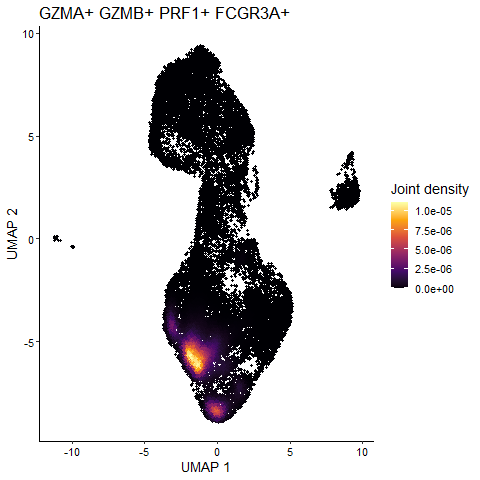

In [6]:
%%R -i resultdir
p <- Plot_Density_Joint_Only(seurat_object = Subbbb, features = c("GZMA","GZMB","PRF1","FCGR3A"),viridis_palette="inferno")
ggsave(plot=p,filename=paste0(resultdir,"Density_GZMA+GZMB+PRF1+FCGR3A+.pdf"),dpi = 600)
ggsave(plot=p,filename=paste0(resultdir,"Density_GZMA+GZMB+PRF1+FCGR3A+.png"),width=10,height=8,dpi = 600)

p

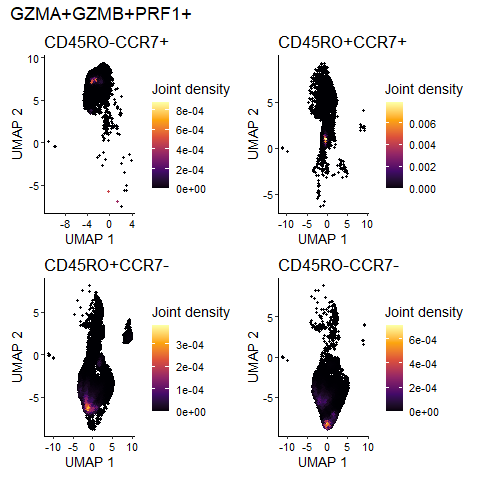

In [7]:
%%R -i resultdir
DefaultAssay(Subbbb) 
p1 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T, features = c("GZMA","GZMB","PRF1"),viridis_palette='inferno')+ggtitle("CD45RO-CCR7+")
p2 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T, features = c("GZMA","GZMB","PRF1"),viridis_palette='inferno')+ggtitle("CD45RO+CCR7+")
p3 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T, features = c("GZMA","GZMB","PRF1"),viridis_palette='inferno')+ggtitle("CD45RO+CCR7-")
p4 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T, features = c("GZMA","GZMB","PRF1"),viridis_palette='inferno')+ggtitle("CD45RO-CCR7-")
pall <- p1+p2+p3+p4 +  
    plot_layout(ncol = 2)+ 
    plot_annotation(title = 'GZMA+GZMB+PRF1+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=pall,filename=paste0(resultdir,"Density_Split_GZMA+GZMB+PRF1+.pdf"),width=10,height=8,dpi = 600)
pall

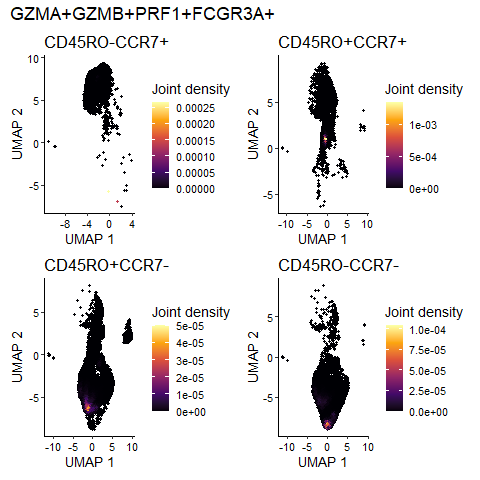

In [13]:
%%R
DefaultAssay(Subbbb) 
p1 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T, features = c("GZMA","GZMB","PRF1","FCGR3A"),viridis_palette='inferno')+ggtitle("CD45RO-CCR7+")
p2 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T, features = c("GZMA","GZMB","PRF1","FCGR3A"),viridis_palette='inferno')+ggtitle("CD45RO+CCR7+")
p3 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T, features = c("GZMA","GZMB","PRF1","FCGR3A"),viridis_palette='inferno')+ggtitle("CD45RO+CCR7-")
p4 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T, features = c("GZMA","GZMB","PRF1","FCGR3A"),viridis_palette='inferno')+ggtitle("CD45RO-CCR7-")
pall <- p1+p2+p3+p4 +  
    plot_layout(ncol = 2)+ 
    plot_annotation(title = 'GZMA+GZMB+PRF1+FCGR3A+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=pall,filename=paste0(resultdir,"Density_Split_GZMA+GZMB+PRF1+FCGR3A+.pdf"),width=10,height=8,dpi = 600)
pall

In [ ]:
%%R
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMA+GZMB+PRF1+FCGR3A+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+GZMB+PRF1+FCGR3A+.png"),width=15,height=8,dpi = 600)
p_all

In [14]:
%%R
DefaultAssay(Subbbb) 

[1] "SCT"


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for 

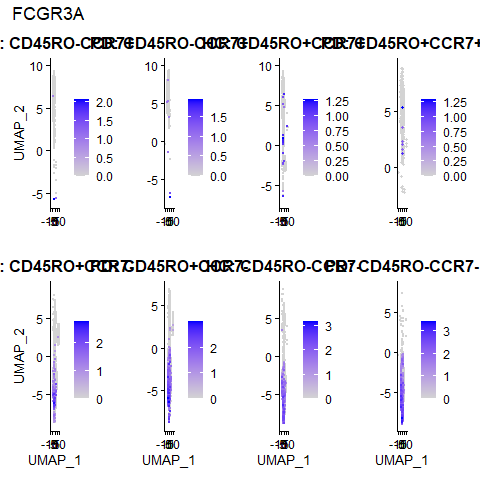

In [15]:
%%R -i resultdir
DefaultAssay(Subbbb) <- "SCT"

individual_features = c("GZMA","GZMB","GZMH","GZMK","PRF1","FCGR3A")
lapply(individual_features,FUN=function(i_feature){
    p11 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROm_T_HC, features = i_feature)+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
    p12 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROm_T_PD, features = i_feature)+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

    p21 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROp_T_HC, features = i_feature)+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
    p22 <- Plot_Density_Custom(seurat_object = CCR7pCD45ROp_T_PD, features = i_feature)+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

    p31 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROp_T_HC, features = i_feature)+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
    p32 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROp_T_PD, features = i_feature)+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

    p41 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROm_T_HC, features = i_feature)+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
    p42 <- Plot_Density_Custom(seurat_object = CCR7mCD45ROm_T_PD, features = i_feature)+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

    p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
        plot_layout(ncol = 4)+ 
        plot_annotation(title = i_feature, theme = theme(plot.title = element_text(size = 18)))

    ggsave(plot=p_all,filename=paste0(resultdir,"Density_",i_feature,".pdf"),width=15,height=8,dpi = 600)
    p_all


    p11 <- FeaturePlot(object = CCR7pCD45ROm_T_HC, features = i_feature,order=T)+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
    p12 <- FeaturePlot(object = CCR7pCD45ROm_T_PD, features = i_feature,order=T)+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

    p21 <- FeaturePlot(object = CCR7pCD45ROp_T_HC, features = i_feature,order=T)+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
    p22 <- FeaturePlot(object = CCR7pCD45ROp_T_PD, features = i_feature,order=T)+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

    p31 <- FeaturePlot(object = CCR7mCD45ROp_T_HC, features = i_feature,order=T)+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
    p32 <- FeaturePlot(object = CCR7mCD45ROp_T_PD, features = i_feature,order=T)+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

    p41 <- FeaturePlot(object = CCR7mCD45ROm_T_HC, features = i_feature,order=T)+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
    p42 <- FeaturePlot(object = CCR7mCD45ROm_T_PD, features = i_feature,order=T)+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

    p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
        plot_layout(ncol = 4)+ 
        plot_annotation(title = i_feature, theme = theme(plot.title = element_text(size = 18)))

    ggsave(plot=p_all,filename=paste0(resultdir,"FeaturePlot_",i_feature,".pdf"),width=15,height=8,dpi = 600)
    p_all
})


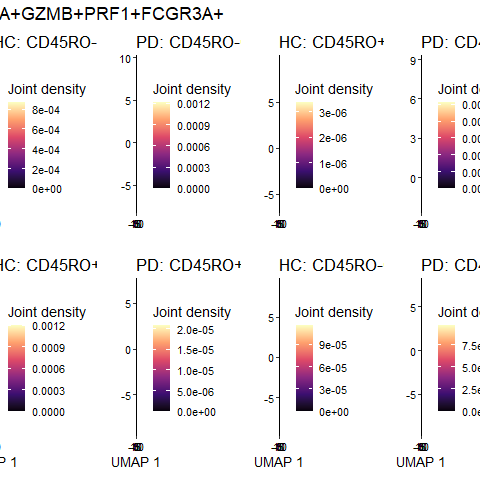

In [10]:
%%R -i resultdir
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_HC, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_PD, features = c("GZMA","GZMB","PRF1","FCGR3A"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMA+GZMB+PRF1+FCGR3A+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+GZMB+PRF1+FCGR3A+.pdf"),width=15,height=8,dpi = 600)
ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+GZMB+PRF1+FCGR3A+.png"),width=15,height=8,dpi = 600)
p_all

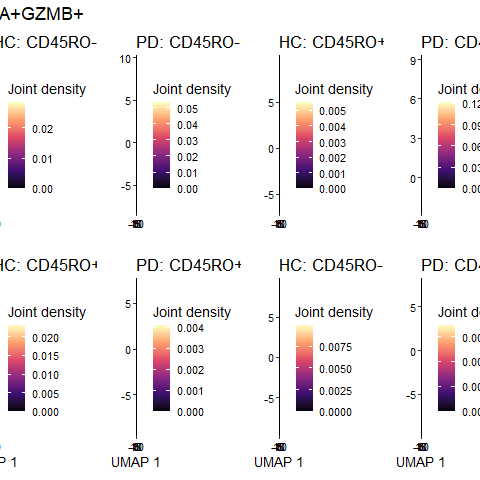

In [16]:
%%R
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_HC, features = c("GZMA","GZMB"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_PD, features = c("GZMA","GZMB"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_HC, features = c("GZMA","GZMB"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_PD, features = c("GZMA","GZMB"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_HC, features = c("GZMA","GZMB"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_PD, features = c("GZMA","GZMB"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_HC, features = c("GZMA","GZMB"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_PD, features = c("GZMA","GZMB"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMA+GZMB+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Density_GZMA+GZMB+.pdf"),width=15,height=8,dpi = 600)
p_all

In [ ]:
%%R -i resultdir
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMA+PRF1+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+PRF1+.pdf"),width=15,height=8,dpi = 600)
ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+PRF1+.png"),width=15,height=8,dpi = 600)
p_all

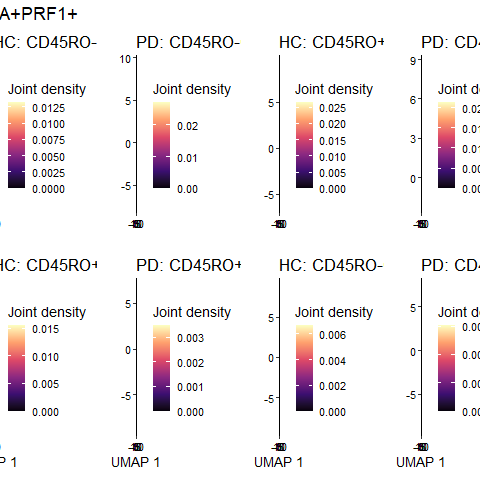

In [10]:
%%R -i resultdir
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_HC, features = c("GZMA","PRF1"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_PD, features = c("GZMA","PRF1"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMA+PRF1+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+PRF1+.pdf"),width=15,height=8,dpi = 600)
ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+PRF1+.png"),width=15,height=8,dpi = 600)
p_all

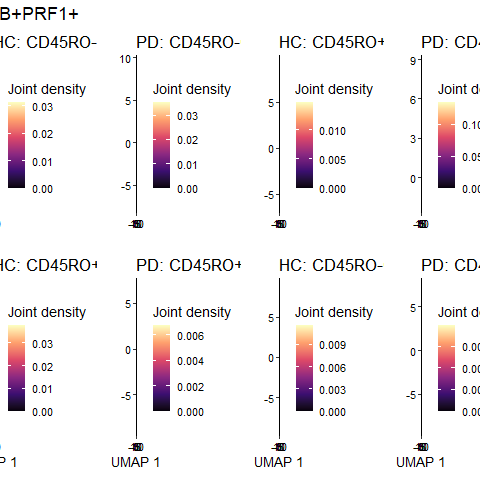

In [17]:
%%R
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_HC, features = c("GZMB","PRF1"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_PD, features = c("GZMB","PRF1"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_HC, features = c("GZMB","PRF1"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_PD, features = c("GZMB","PRF1"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_HC, features = c("GZMB","PRF1"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_PD, features = c("GZMB","PRF1"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_HC, features = c("GZMB","PRF1"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_PD, features = c("GZMB","PRF1"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMB+PRF1+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Density_GZMB+PRF1+.pdf"),width=15,height=8,dpi = 600)
p_all

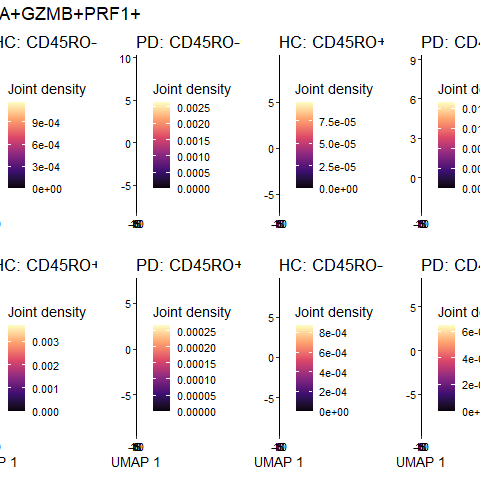

In [40]:
%%R
p11 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_HC, features = c("GZMA","GZMB","PRF1"))+ggtitle("HC: CD45RO-CCR7+")+xlab("")+xlim(-10,10)
p12 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROm_T_PD, features = c("GZMA","GZMB","PRF1"))+ggtitle("PD: CD45RO-CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p21 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_HC, features = c("GZMA","GZMB","PRF1"))+ggtitle("HC: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)
p22 <- Plot_Density_Joint_Only(seurat_object = CCR7pCD45ROp_T_PD, features = c("GZMA","GZMB","PRF1"))+ggtitle("PD: CD45RO+CCR7+")+xlab("")+ylab("")+xlim(-10,10)

p31 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_HC, features = c("GZMA","GZMB","PRF1"))+ggtitle("HC: CD45RO+CCR7-")+xlim(-10,10)
p32 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROp_T_PD, features = c("GZMA","GZMB","PRF1"))+ggtitle("PD: CD45RO+CCR7-")+ylab("")+xlim(-10,10)

p41 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_HC, features = c("GZMA","GZMB","PRF1"))+ggtitle("HC: CD45RO-CCR7-")+ylab("")+xlim(-10,10)
p42 <- Plot_Density_Joint_Only(seurat_object = CCR7mCD45ROm_T_PD, features = c("GZMA","GZMB","PRF1"))+ggtitle("PD: CD45RO-CCR7-")+ylab("")+xlim(-10,10)

p_all <- p11+p12+p21+p22+p31+p32+p41+p42 +  
    plot_layout(ncol = 4)+ 
    plot_annotation(title = 'GZMA+GZMB+PRF1+', theme = theme(plot.title = element_text(size = 18)))

ggsave(plot=p_all,filename=paste0(resultdir,"Subset_Density_GZMA+GZMB+PRF1+.png"),width=15,height=8,dpi = 600)
p_all

In [41]:
%%R
DefaultAssay(Subbbb) <- "SCT"
Subbbb$CellType <- factor(Subbbb$CellType ,levels=c("CCR7pCD45ROm", "CCR7pCD45ROp", "CCR7mCD45ROp", "CCR7mCD45ROm")) 
Subbbb$CCellType <- factor(Subbbb$CCellType ,levels=c("CD45RO-CCR7+", "CD45RO+CCR7+", "CD45RO+CCR7-", "CD45RO-CCR7-")) 


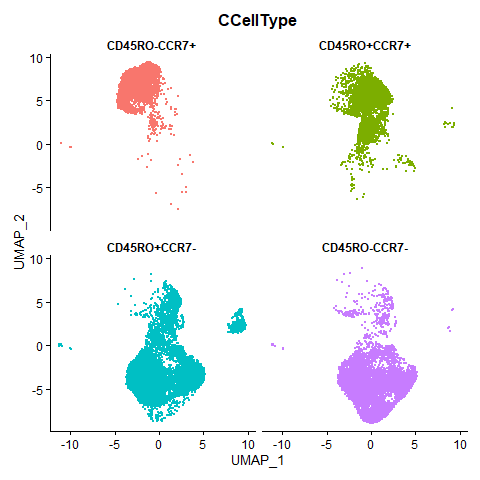

In [42]:
%%R 
DimPlot(Subbbb, reduction = "umap", group.by = "CCellType",split.by="CCellType",ncol=2)+NoLegend()

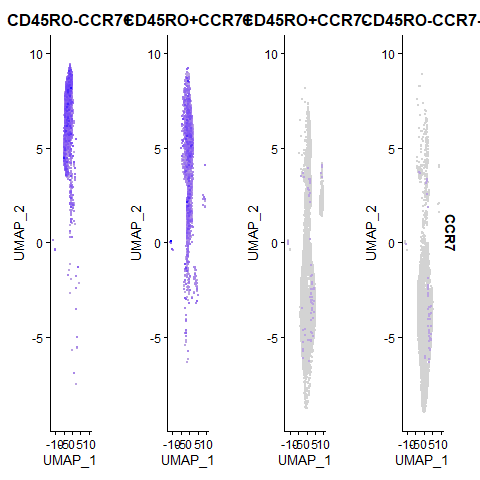

In [43]:
%%R 
FeaturePlot(Subbbb, reduction = "umap",features="CCR7",order=T, split.by="CCellType")+NoLegend()

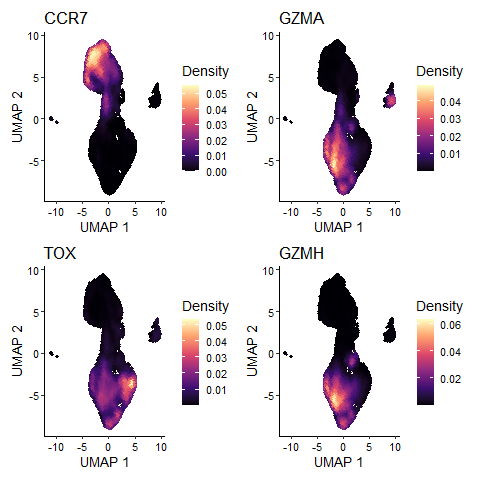

In [22]:
%%R
DefaultAssay(Subbbb) <- "SCT"

library(scCustomize)
p1 <- Plot_Density_Custom(seurat_object =Subbbb, features = c("CCR7","GZMA"))
p2 <-Plot_Density_Custom(seurat_object = Subbbb, features = c("TOX","GZMH"))
p_all <- p1/p2

ggsave(plot=p_all,filename=paste0(resultdir,"Sep_Density_CCR7_GZMA_TOX_GZMH.pdf"),width=10,height=8,dpi = 600)
p_all

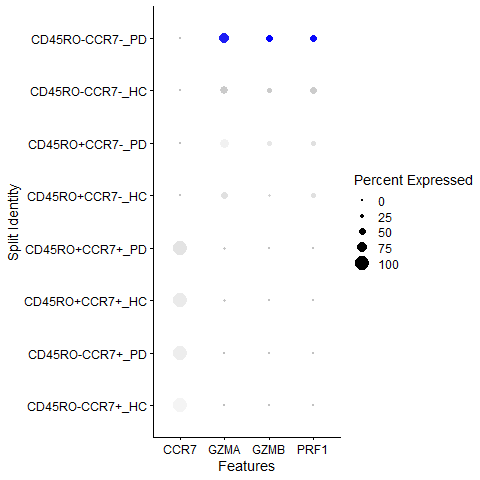

In [46]:
%%R
DotPlot(Subbbb, features = c("CCR7","GZMZ","GZMA","GZMB","PRF1"),
    split.by="Condition",
    group.by="CCellType")

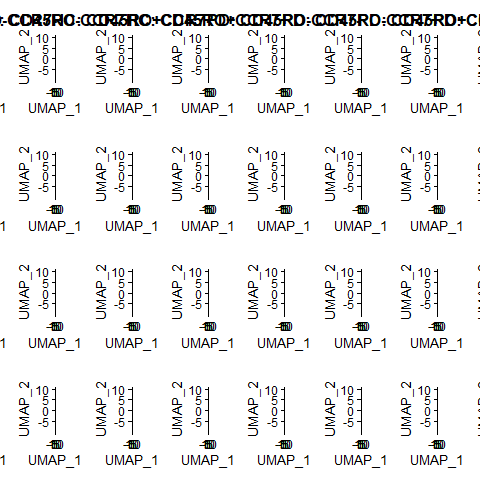

In [47]:
%%R -i resultdir
Subbbb$Combined <- paste0(Subbbb$Condition, ": ", Subbbb$CCellType) 

p1 <- FeaturePlot(Subbbb, features = c("CCR7","GZMA","GZMB","PRF1"),order=T,split.by="Combined",ncol=4)
ggsave(plot=p1,filename=paste0(resultdir,"Subset_Feature_GZMA+GZMB+PRF1+.png"),width=25,height=10,dpi = 600)
p1

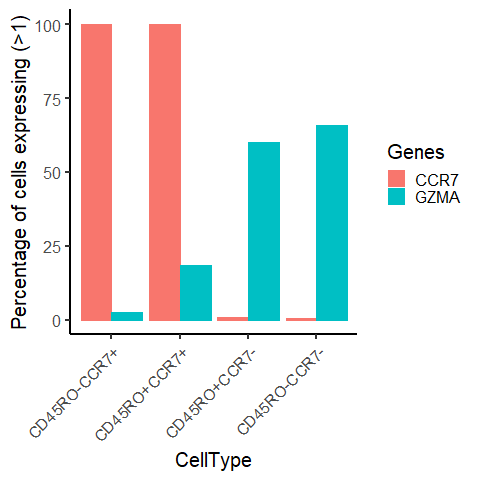

In [48]:
%%R
percent_express <- Percent_Expressing(seurat_object = Subbbb,
    assay="RNA",
    features = c("CCR7","GZMA"),
    group_by = "CellType")
df_percent <- as.data.frame(percent_express)
df_percent_melt <- as.data.frame(reshape2::melt(as.matrix(df_percent)))
df_percent_melt
df_percent_melt$CellType <- as.vector(df_percent_melt$Var2)
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7mCD45ROm"] <- "CD45RO-CCR7-"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7pCD45ROp"] <- "CD45RO+CCR7+"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7pCD45ROm"] <- "CD45RO-CCR7+"
df_percent_melt$CellType[df_percent_melt$Var2 == "CCR7mCD45ROp"] <- "CD45RO+CCR7-"
df_percent_melt$CellType <- factor(df_percent_melt$CellType ,levels=c("CD45RO-CCR7+", "CD45RO+CCR7+", "CD45RO+CCR7-", "CD45RO-CCR7-")) 
colnames(df_percent_melt)[1] <- "Genes"
ggplot(df_percent_melt,aes(x=CellType,y=value,color=Genes,fill=Genes))+
    geom_bar(stat="identity",, position=position_dodge())+
    ylab("Percentage of cells expressing (>1)")+
    xlab("CellType")+
    theme_classic(base_size = 20)+RotatedAxis()

In [93]:
%%R
percent_express

     CCR7pCD45ROp CCR7pCD45ROm CCR7mCD45ROm CCR7mCD45ROp
CCR7    100.00000   100.000000    0.6643599    0.7485197
GZMA     18.45519     2.773556   65.8961938   60.1720478


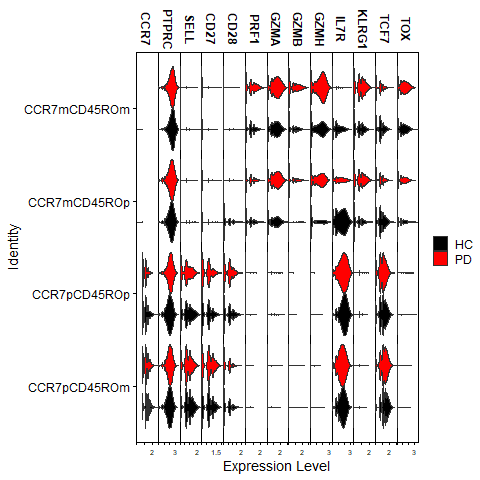

In [49]:
%%R
DefaultAssay(Subbbb) <- "SCT"
Subbbb <- SetIdent(Subbbb , value = "CellType")
VlnPlot(Subbbb , features = c("CCR7","PTPRC", "SELL", "CD27", "CD28", "PRF1", "GZMA", "GZMB", "GZMH", "IL7R", "KLRG1", "TCF7", "TOX"),
    cols=c("black","red"),
    stack=T,
    split.by = "Condition",
    pt.size=0)

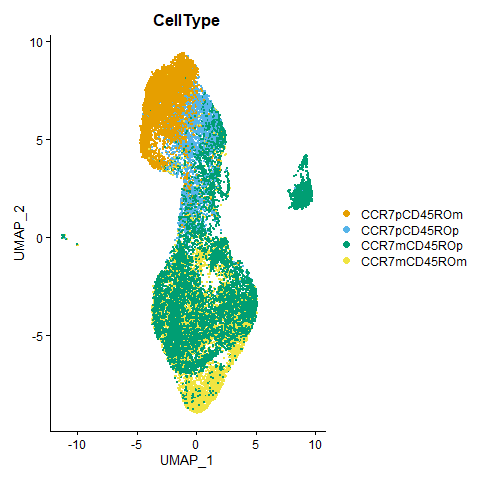

In [27]:
%%R
library(dittoSeq)
p<- DimPlot(Subbbb , reduction = "umap", group.by = "CellType",label=F,cols=c(dittoColors(1)[seq_len(4)]))
ggsave(plot=p,filename=paste0(resultdir,"DimPlot_CellTYpe.pdf"),width=10,height=8,dpi = 600)

p

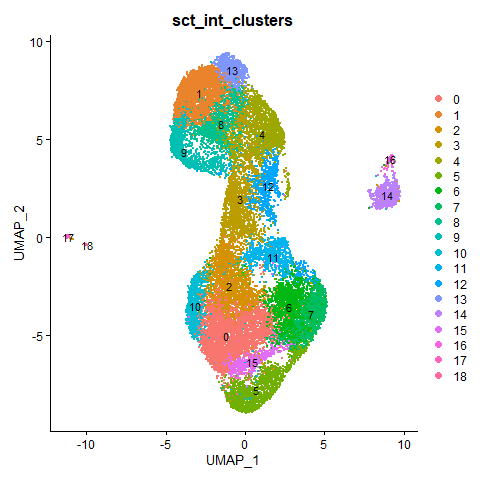

In [50]:
%%R
DimPlot(Subbbb , reduction = "umap", group.by = "sct_int_clusters",label=T)

In [84]:
%%R
saveRDS(Subbbb, "Subset_raarranged.rds")

In [4]:
%%R
Subbbb <- readRDS("Subset_raarranged.rds")

In [5]:
%%R
DefaultAssay(Subbbb) <- "SCT"
library(dplyr)
Idents(Subbbb) <- "sct_int_clusters"
Subbbb <- PrepSCTFindMarkers(Subbbb)
markers_df <- FindAllMarkers(Subbbb, only.pos =T )


  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 3 % ~07s           |++                                                | 4 % ~07s           |+++                                               | 5 % ~07s           |++++                                              | 6 % ~07s           |++++                                              | 8 % ~06s           |+++++                                             | 9 % ~06s           |++++++                                            | 10% ~06s           |++++++                                            | 11% ~06s           |+++++++                                           | 13% ~06s           |+++++++                                           | 14% ~06s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 16% ~06s 

In [6]:
%%R
markers_df[1:4,1:4]

       p_val avg_log2FC pct.1 pct.2
GNLY       0   2.142533 0.881 0.286
NKG7       0   1.717048 0.997 0.517
GZMH       0   1.671206 0.931 0.270
FGFBP2     0   1.391811 0.706 0.160


In [7]:
%%R
markers_df  <- markers_df  %>% mutate(enrichment.ratio = pct.1 / (pct.2 + .000001),
                diff.pct = pct.1 - pct.2,
                gene.score = avg_log2FC * enrichment.ratio)
markers_df  <- markers_df  %>% 
    dplyr::select(gene, cluster, gene.score, p_val_adj, diff.pct, enrichment.ratio,
                    pct.1, pct.2, avg_log2FC) %>%
        mutate(across(where(is.numeric), .f = ~ round(.x, 5)))
markers_df  <- markers_df  %>% group_by(cluster) %>%
            arrange(desc(gene.score), .by_group = TRUE)

In [8]:
%%R -i resultdir
top10_gs <- markers_df %>%
    group_by(cluster) %>%
    top_n(n = 2, wt = gene.score)
top10_gs
readr::write_tsv(markers_df,paste0(resultdir,"df_cl.csv"))

top10_fc <- markers_df %>%
    group_by(cluster) %>%
    top_n(n = 2, wt = avg_log2FC)


In [9]:
%%R -i resultdir
library(dittoSeq)
avg_SCT_cl <- AverageExpression(Subbbb,group.by="Combined",return.seurat = T)

In [14]:
%%R
unique(avg_SCT_cl$Cluster)

[1] " CD45RO-CCR7-" " CD45RO-CCR7+" " CD45RO+CCR7-" " CD45RO+CCR7+"


In [13]:
%%R
library(stringr)
avg_SCT_cl$Cluster <- unlist(lapply(colnames(avg_SCT_cl),function(x){str_split(x,pattern="_")[[1]][1]}))
# avg_SCT_cl$Cluster <- factor(avg_SCT_cl$Cluster,levels=c(0:20))
avg_SCT_cl$Condition <- unlist(lapply(colnames(avg_SCT_cl),function(x){str_split(x,pattern="_")[[1]][2]}))


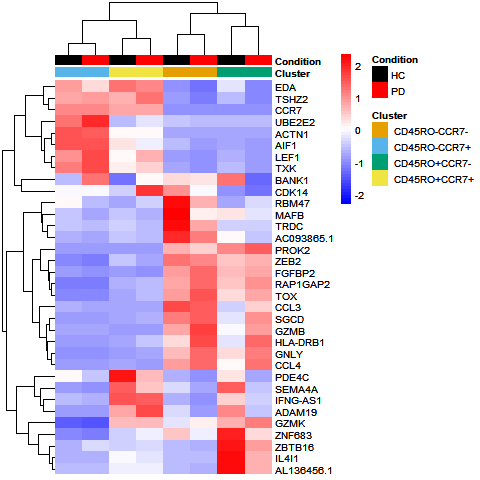

In [28]:
%%R -i resultdir
dittoHeatmap(avg_SCT_cl,unique(top10_gs$gene), annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=T)#,filename=paste0(resultdir,"Heatmap_cl_hierarchical.png"),width=15)

In [20]:
%%R
Subbbb$Combined_cl <- paste0(Subbbb$Condition, ": ", Subbbb$sct_int_clusters) 

unique(Subbbb$Combined_cl)

 [1] "HC: 2"  "HC: 13" "HC: 3"  "HC: 4"  "HC: 8"  "HC: 1"  "HC: 12" "HC: 7" 
 [9] "HC: 9"  "HC: 10" "HC: 6"  "HC: 0"  "HC: 15" "HC: 14" "HC: 18" "HC: 11"
[17] "HC: 16" "HC: 17" "HC: 5"  "PD: 3"  "PD: 12" "PD: 4"  "PD: 8"  "PD: 9" 
[25] "PD: 1"  "PD: 13" "PD: 18" "PD: 6"  "PD: 2"  "PD: 14" "PD: 10" "PD: 7" 
[33] "PD: 5"  "PD: 0"  "PD: 11" "PD: 15" "PD: 17" "PD: 16"


In [33]:
%%R
Subbbb$Combined_cl <- paste0(Subbbb$Condition, ": ", Subbbb$sct_int_clusters) 
avg_SCT_cl2 <- AverageExpression(Subbbb,group.by="Combined_cl",return.seurat = T)
avg_SCT_cl2$Cluster <- unlist(lapply(colnames(avg_SCT_cl2),function(x){str_split(x,pattern="_")[[1]][1]}))
# avg_SCT_cl2$Cluster <- factor(avg_SCT_cl2$Cluster,levels=c(0:max(as.numeric(Subbbb$sct_int_clusters))))
avg_SCT_cl2$Condition <- unlist(lapply(colnames(avg_SCT_cl2),function(x){str_split(x,pattern="_")[[1]][2]}))


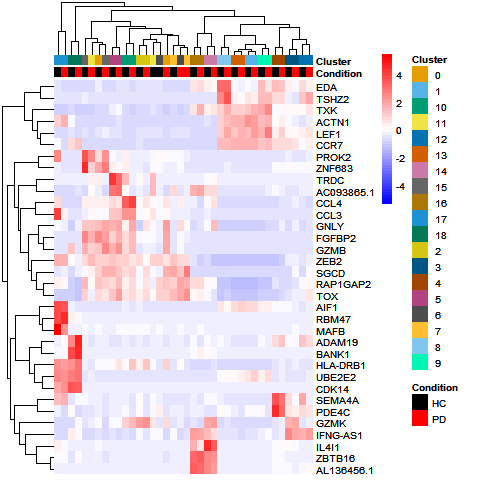

In [38]:
%%R
dittoHeatmap(avg_SCT_cl2,unique(top10_gs$gene),annot.colors = c(c("black","red"),dittoColors(1)[seq_len(19)]),
    annot.by = c("Condition","Cluster"),cluster_cols=T)#,filename=paste0(resultdir,"Heatmap_cl_hierarchical.png"),width=15)

In [57]:
%%R
DefaultAssay(Subbbb) <- "SCT"

## CCR7mCD45ROm

In [58]:
%%R
library(DESeq2)
CCR7mCD45ROm = subset(Subbbb, subset= CellType =="CCR7mCD45ROm")
CCR7mCD45ROm<- SetIdent(CCR7mCD45ROm , value = "Condition")
CCR7mCD45ROm <- PrepSCTFindMarkers(CCR7mCD45ROm)


In [59]:
%%R
DE_CCR7mCD45ROm <-  FindMarkers(CCR7mCD45ROm,ident.1="PD",ident.2="HC",
    min.pct = 0.5,
    logfc.threshold = 0
    )

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~19s           |+                                                 | 2 % ~19s           |++                                                | 3 % ~19s           |++                                                | 4 % ~19s           |+++                                               | 5 % ~19s           |+++                                               | 6 % ~18s           |++++                                              | 7 % ~18s           |++++                                              | 8 % ~18s           |+++++                                             | 9 % ~18s           |+++++                                             | 10% ~18s           |++++++                                            | 11% ~17s           |++++++                                            | 12% ~17s           |+++++++                                           | 13% ~17s 

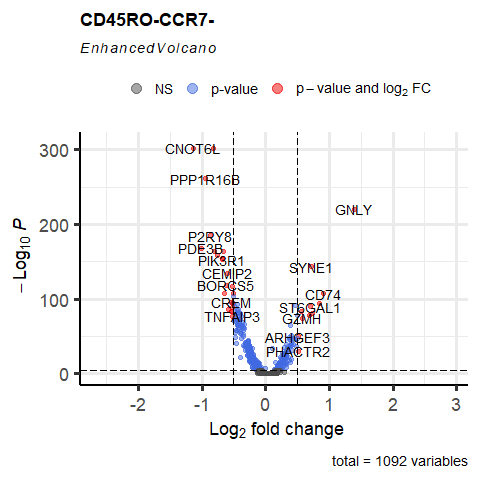

In [60]:
%%R
library(EnhancedVolcano)
EnhancedVolcano(DE_CCR7mCD45ROm,
    lab = rownames(DE_CCR7mCD45ROm),
    x = 'avg_log2FC',
    y = 'p_val_adj',FCcutoff = 0.5,title="CD45RO-CCR7-")

In [61]:
%%R -i resultdir
DE_CCR7mCD45ROm[1:4,1:4]

                 p_val avg_log2FC pct.1 pct.2
CNOT6L    0.000000e+00 -1.1301380 0.790 0.955
SAMSN1   2.473453e-306 -0.8184968 0.121 0.518
PPP1R16B 4.295805e-266 -0.9393919 0.621 0.902
GNLY     2.328610e-225  1.4009399 0.713 0.382


In [62]:
%%R -i resultdir
DE_CCR7mCD45ROm$gene <- rownames(DE_CCR7mCD45ROm)
DE_CCR7mCD45ROm$cluster <- unlist(lapply(abs(DE_CCR7mCD45ROm$avg_log2FC),function(x){if (  x > 1 ) { "PD" } else { "HC" }}))

DE_CCR7mCD45ROm  <- DE_CCR7mCD45ROm  %>% mutate(enrichment.ratio = pct.1 / (pct.2 + .000001),
                diff.pct = pct.1 - pct.2,
                gene.score = avg_log2FC * enrichment.ratio)
DE_CCR7mCD45ROm  <- DE_CCR7mCD45ROm  %>% 
    dplyr::select(gene, gene.score, p_val_adj, diff.pct, enrichment.ratio,
                    pct.1, pct.2, avg_log2FC,cluster) %>%
        mutate(across(where(is.numeric), .f = ~ round(.x, 5)))
DE_CCR7mCD45ROm  <- DE_CCR7mCD45ROm  %>% group_by(cluster) %>%
            arrange(desc(gene.score), .by_group = TRUE)

readr::write_tsv(DE_CCR7mCD45ROm[order(DE_CCR7mCD45ROm$gene.score,decreasing=T),],file=paste0(resultdir,"DE_CCR7mCD45ROm.tsv"))

## CCR7mCD45ROp

In [63]:
%%R
CCR7mCD45ROp = subset(Subbbb, subset= CellType =="CCR7mCD45ROp")
CCR7mCD45ROp<- SetIdent(CCR7mCD45ROp , value = "Condition")
CCR7mCD45ROp <- PrepSCTFindMarkers(CCR7mCD45ROp)
DE_CCR7mCD45ROp <-  FindMarkers(CCR7mCD45ROp,ident.1="PD",ident.2="HC",
    min.pct = 0.5,
    logfc.threshold = 0)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~17s           |++                                                | 2 % ~16s           |++                                                | 3 % ~15s           |+++                                               | 4 % ~15s           |+++                                               | 5 % ~15s           |++++                                              | 6 % ~15s           |++++                                              | 7 % ~14s           |+++++                                             | 8 % ~15s           |+++++                                             | 9 % ~14s           |++++++                                            | 11% ~14s           |++++++                                            | 12% ~14s           |+++++++                                           | 13% ~14s           |+++++++                                           | 14% ~14s 

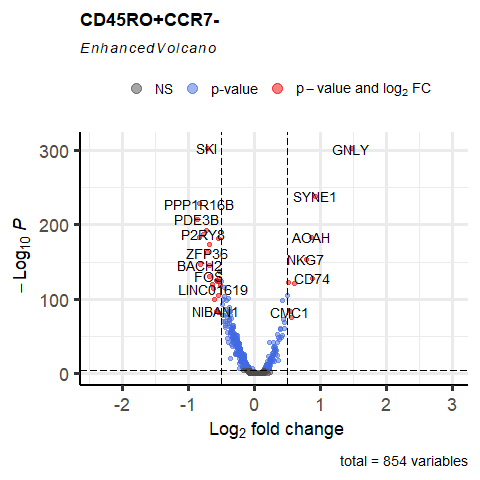

In [64]:
%%R
EnhancedVolcano(DE_CCR7mCD45ROp,
    lab = rownames(DE_CCR7mCD45ROp),
    x = 'avg_log2FC',
    y = 'p_val_adj',FCcutoff = 0.5,title="CD45RO+CCR7-")

In [65]:
%%R -i resultdir
DE_CCR7mCD45ROp$gene <- rownames(DE_CCR7mCD45ROp)
DE_CCR7mCD45ROp$cluster <- unlist(lapply(abs(DE_CCR7mCD45ROp$avg_log2FC),function(x){if (  x > 1 ) { "PD" } else { "HC" }}))

DE_CCR7mCD45ROp  <- DE_CCR7mCD45ROp  %>% mutate(enrichment.ratio = pct.1 / (pct.2 + .000001),
                diff.pct = pct.1 - pct.2,
                gene.score = avg_log2FC * enrichment.ratio)
DE_CCR7mCD45ROp  <- DE_CCR7mCD45ROp  %>% 
    dplyr::select(gene, gene.score, p_val_adj, diff.pct, enrichment.ratio,
                    pct.1, pct.2, avg_log2FC,cluster) %>%
        mutate(across(where(is.numeric), .f = ~ round(.x, 5)))
DE_CCR7mCD45ROp  <- DE_CCR7mCD45ROp  %>% group_by(cluster) %>%
            arrange(desc(gene.score), .by_group = TRUE)
readr::write_tsv(DE_CCR7mCD45ROp[order(DE_CCR7mCD45ROp$gene.score,decreasing=T),],file=paste0(resultdir,"DE_CCR7mCD45ROp.tsv"))

## CCR7pCD45ROm

In [66]:
%%R
CCR7pCD45ROm = subset(Subbbb, subset= CellType =="CCR7pCD45ROm")
CCR7pCD45ROm<- SetIdent(CCR7pCD45ROm , value = "Condition")
CCR7pCD45ROm
CCR7pCD45ROm <- PrepSCTFindMarkers(CCR7pCD45ROm)
DE_CCR7pCD45ROm <-  FindMarkers(CCR7pCD45ROm,ident.1="PD",ident.2="HC",
    min.pct = 0.5,
    logfc.threshold = 0)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~17s           |++                                                | 2 % ~18s           |++                                                | 3 % ~19s           |+++                                               | 4 % ~19s           |+++                                               | 5 % ~19s           |++++                                              | 6 % ~19s           |++++                                              | 7 % ~19s           |+++++                                             | 8 % ~19s           |+++++                                             | 9 % ~18s           |++++++                                            | 10% ~18s           |++++++                                            | 11% ~18s           |+++++++                                           | 12% ~18s           |+++++++                                           | 13% ~17s 

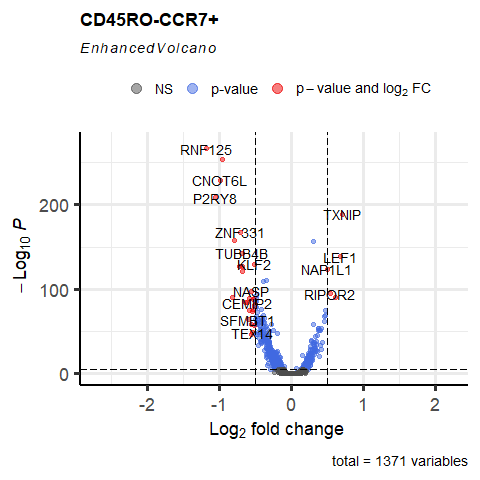

In [67]:
%%R
EnhancedVolcano(DE_CCR7pCD45ROm,
    lab = rownames(DE_CCR7pCD45ROm),
    x = 'avg_log2FC',
    y = 'p_val_adj',FCcutoff = 0.5,title="CD45RO-CCR7+")

In [68]:
%%R -i resultdir
DE_CCR7pCD45ROm$gene <- rownames(DE_CCR7pCD45ROm)
DE_CCR7pCD45ROm$cluster <- unlist(lapply(abs(DE_CCR7pCD45ROm$avg_log2FC),function(x){if (  x > 1 ) { "PD" } else { "HC" }}))

DE_CCR7pCD45ROm  <- DE_CCR7pCD45ROm  %>% mutate(enrichment.ratio = pct.1 / (pct.2 + .000001),
                diff.pct = pct.1 - pct.2,
                gene.score = avg_log2FC * enrichment.ratio)
DE_CCR7pCD45ROm  <- DE_CCR7pCD45ROm  %>% 
    dplyr::select(gene, gene.score, p_val_adj, diff.pct, enrichment.ratio,
                    pct.1, pct.2, avg_log2FC,cluster) %>%
        mutate(across(where(is.numeric), .f = ~ round(.x, 5)))
DE_CCR7pCD45ROm  <- DE_CCR7pCD45ROm  %>% group_by(cluster) %>%
            arrange(desc(gene.score), .by_group = TRUE)
readr::write_tsv(DE_CCR7pCD45ROm[order(DE_CCR7pCD45ROm$gene.score,decreasing=T),],file=paste0(resultdir,"DE_CCR7pCD45ROm.tsv"))

## CCR7pCD45ROp

In [69]:
%%R
library(DESeq2)
CCR7pCD45ROp = subset(Subbbb, subset= CellType =="CCR7pCD45ROp")
CCR7pCD45ROp<- SetIdent(CCR7pCD45ROp , value = "Condition")
CCR7pCD45ROp <- PrepSCTFindMarkers(CCR7pCD45ROp)


In [70]:
%%R
DE_CCR7pCD45ROp <-  FindMarkers(CCR7pCD45ROp,ident.1="PD",ident.2="HC",
    min.pct = 0.5,
    logfc.threshold = 0)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~11s           |++                                                | 3 % ~11s           |+++                                               | 4 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 7 % ~10s           |+++++                                             | 8 % ~10s           |+++++                                             | 9 % ~10s           |++++++                                            | 10% ~10s           |++++++                                            | 11% ~10s           |+++++++                                           | 12% ~10s           |+++++++                                           | 13% ~10s 

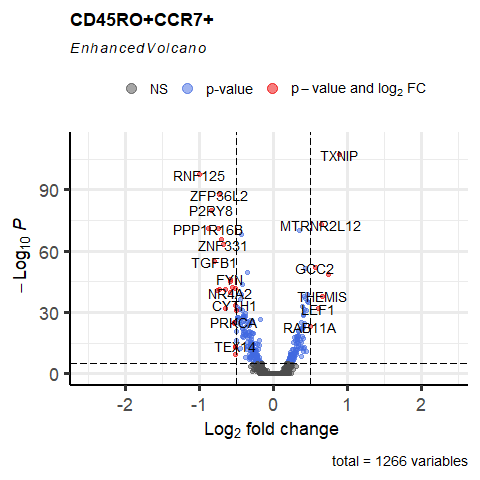

In [71]:
%%R
library(EnhancedVolcano)
EnhancedVolcano(DE_CCR7pCD45ROp,
    lab = rownames(DE_CCR7pCD45ROp),
    x = 'avg_log2FC',
    y = 'p_val_adj',FCcutoff = 0.5,title="CD45RO+CCR7+")

In [72]:
%%R -i resultdir
DE_CCR7pCD45ROp$gene <- rownames(DE_CCR7pCD45ROp)
DE_CCR7pCD45ROp$cluster <- unlist(lapply(abs(DE_CCR7pCD45ROp$avg_log2FC),function(x){if (  x > 1 ) { "PD" } else { "HC" }}))

DE_CCR7pCD45ROp  <- DE_CCR7pCD45ROp  %>% mutate(enrichment.ratio = pct.1 / (pct.2 + .000001),
                diff.pct = pct.1 - pct.2,
                gene.score = avg_log2FC * enrichment.ratio)
DE_CCR7pCD45ROp  <- DE_CCR7pCD45ROp  %>% 
    dplyr::select(gene, gene.score, p_val_adj, diff.pct, enrichment.ratio,
                    pct.1, pct.2, avg_log2FC,cluster) %>%
        mutate(across(where(is.numeric), .f = ~ round(.x, 5)))
DE_CCR7pCD45ROp  <- DE_CCR7pCD45ROp  %>% group_by(cluster) %>%
            arrange(desc(gene.score), .by_group = TRUE)
readr::write_tsv(DE_CCR7pCD45ROp[order(DE_CCR7pCD45ROp$gene.score,decreasing=T),],file=paste0(resultdir,"DE_CCR7pCD45ROp.tsv"))

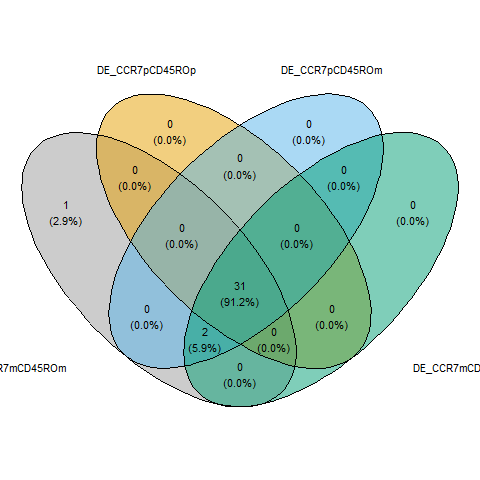

In [73]:
%%R
library(ggvenn)
x <- list( 
    DE_CCR7mCD45ROm = rownames(DE_CCR7mCD45ROm %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    DE_CCR7pCD45ROp = rownames(DE_CCR7pCD45ROp %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    DE_CCR7pCD45ROm = rownames(DE_CCR7pCD45ROm %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    DE_CCR7mCD45ROp = rownames(DE_CCR7mCD45ROp %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05))
)
ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )


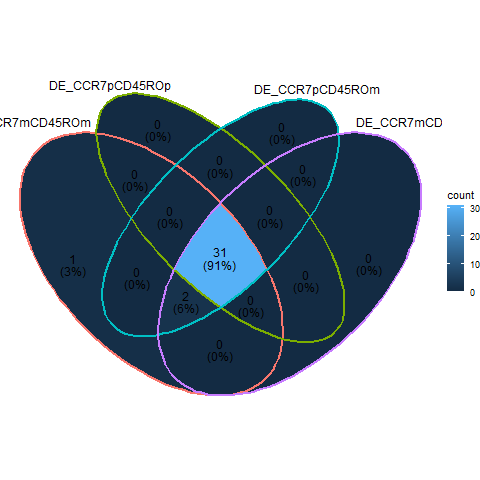

In [56]:
%%R
library("ggVennDiagram")
ggVennDiagram(x, label_alpha = 0)

In [71]:
%%R
Allcommon <- Reduce(intersect,x)
Allcommon


[1] "CNOT6L"  "P2RY8"   "ZNF331"  "RNF125"  "ZFP36L2" "THEMIS" 


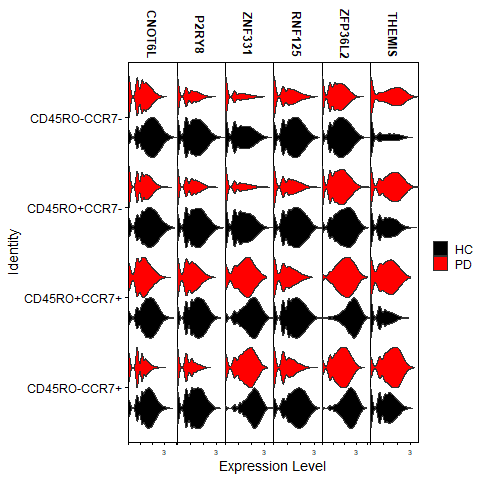

In [86]:
%%R
Idents(Subbbb) <- "CCellType"
VlnPlot(Subbbb, Allcommon,stack=T,split.by="Condition",cols=c("black","red"))

In [73]:
%%R
library(enrichR)
dbs <- listEnrichrDbs()

In [74]:
%%R
colnames(dbs)

[1] "geneCoverage" "genesPerTerm" "libraryName"  "link"         "numTerms"    
[6] "appyter"      "categoryId"  


In [75]:
%%R
list_2021 <- as.vector(grep("2021",unique(dbs$libraryName)))

list_2022 <- as.vector(grep("2022",unique(dbs$libraryName)))

list_parkinson <- as.vector(grep("Parki",unique(dbs$libraryName)))

list_2021
dbs$libraryName[list_2021]

 [1] "Allen_Brain_Atlas_10x_scRNA_2021"    
 [2] "Descartes_Cell_Types_and_Tissue_2021"
 [3] "KEGG_2021_Human"                     
 [4] "WikiPathway_2021_Human"              
 [5] "GO_Biological_Process_2021"          
 [6] "GO_Cellular_Component_2021"          
 [7] "GO_Molecular_Function_2021"          
 [8] "MGI_Mammalian_Phenotype_Level_4_2021"
 [9] "CellMarker_Augmented_2021"           
[10] "Orphanet_Augmented_2021"             
[11] "COVID-19_Related_Gene_Sets_2021"     
[12] "PanglaoDB_Augmented_2021"            
[13] "Azimuth_Cell_Types_2021"             
[14] "PhenGenI_Association_2021"           
[15] "GTEx_Aging_Signatures_2021"          
[16] "HDSigDB_Human_2021"                  
[17] "HDSigDB_Mouse_2021"                  


## GO_Biological_Process_2021

In [88]:
%%R -i resultdir
obj_list_celltype = list(
    "CCR7mCD45ROm" = CCR7mCD45ROm,
    "CCR7pCD45ROp" = CCR7pCD45ROp,
    "CCR7mCD45ROp" = CCR7mCD45ROp,
    "CCR7pCD45ROm" = CCR7pCD45ROm
)

list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="GO_Biological_Process_2021", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)+ theme(text=element_text(size=16))
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_GO_Biological_Process_2021_",celltype_name,".png"),width=10,height=9)
    plot_enrich
})


[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 8 % ~03s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                   

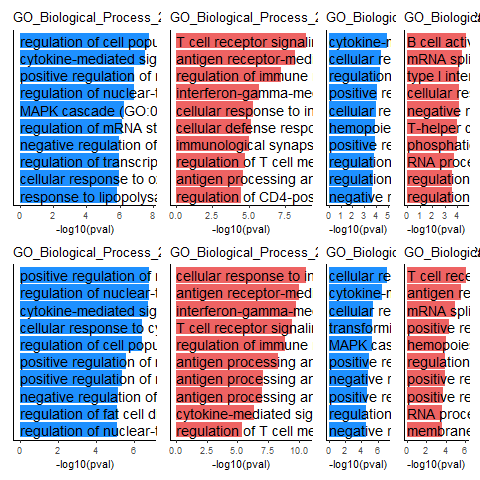

In [77]:
%%R
library(patchwork)
# list_plot_enrich[1]
(list_plot_enrich[[1]]+list_plot_enrich[[2]]) / (list_plot_enrich[[3]]+list_plot_enrich[[4]])

## Reactome_2022

In [78]:
%%R -i resultdir
Reactome_2022_list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="Reactome_2022", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_Reactome_2022_",celltype_name,".png"),width=15,height=12)
    plot_enrich
})

[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                   

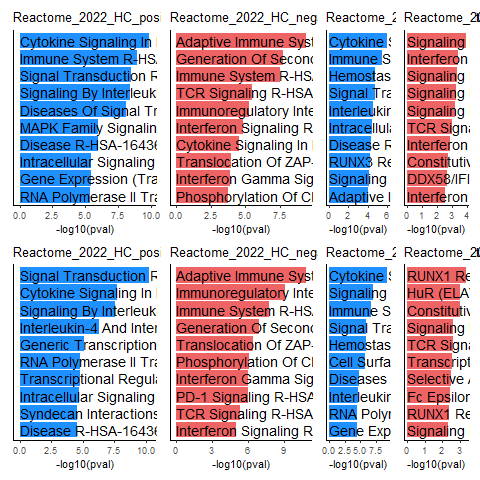

In [79]:
%%R
(Reactome_2022_list_plot_enrich[[1]]+Reactome_2022_list_plot_enrich[[2]]) / 
(Reactome_2022_list_plot_enrich[[3]]+Reactome_2022_list_plot_enrich[[4]])

## KEGG_2021_Human

In [90]:
%%R -i resultdir
KEGG_2021_Human_list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="KEGG_2021_Human", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_KEGG_2021_Human_",celltype_name,".png"))
    plot_enrich
})



[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~03s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                   

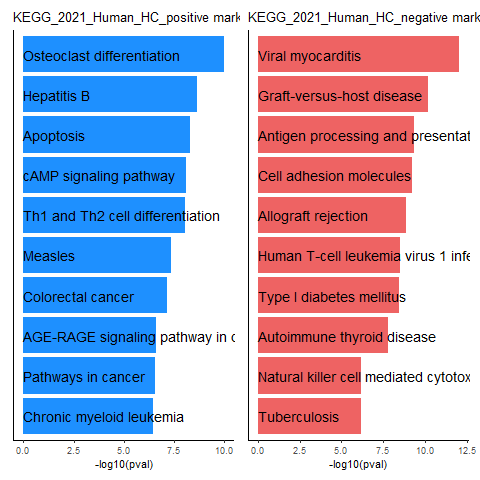

In [92]:
%%R
KEGG_2021_Human_list_plot_enrich[[1]]

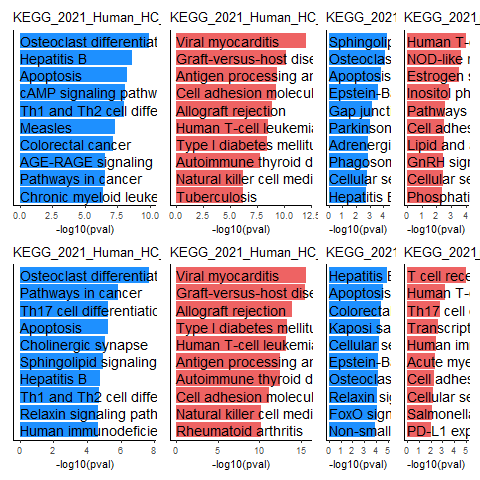

In [81]:
%%R
(KEGG_2021_Human_list_plot_enrich[[1]]+KEGG_2021_Human_list_plot_enrich[[2]]) / 
(KEGG_2021_Human_list_plot_enrich[[3]]+KEGG_2021_Human_list_plot_enrich[[4]])

## WikiPathway_2021_Human

In [82]:
%%R -i resultdir
WikiPathway_2021_Human_list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="WikiPathway_2021_Human", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_WikiPathway_2021_Human_",celltype_name,".png"))
    plot_enrich
})


[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 8 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 10% ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |+++++++                                   

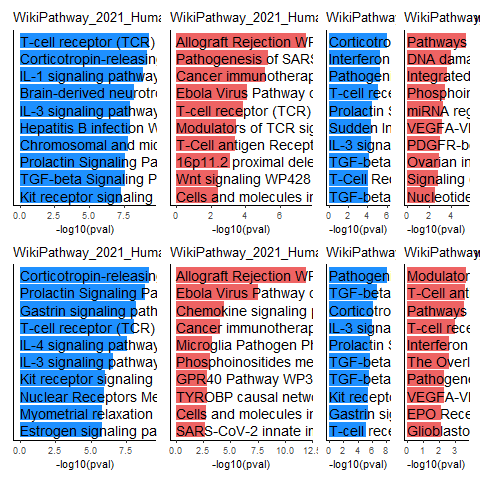

In [83]:
%%R
(WikiPathway_2021_Human_list_plot_enrich[[1]]+WikiPathway_2021_Human_list_plot_enrich[[2]]) / 
(WikiPathway_2021_Human_list_plot_enrich[[3]]+WikiPathway_2021_Human_list_plot_enrich[[4]])

In [ ]:
%%R
saveRDS()

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is

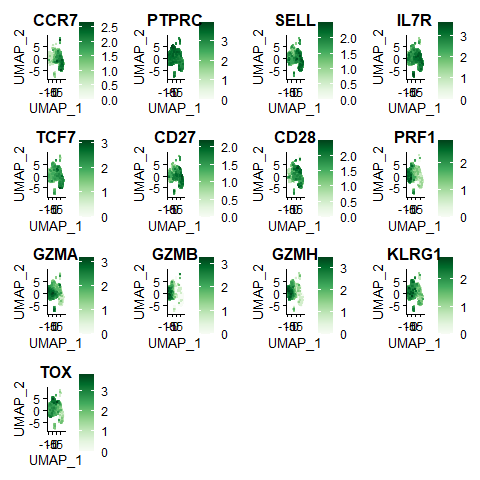

In [69]:
%%R -i resultdir
library(RColorBrewer)
DefaultAssay(SCT.combined) <- "SCT"
pfeat <- FeaturePlot(SCT.combined, features=c("CCR7","PTPRC", "SELL","IL7R","TCF7", "CD27", "CD28", "PRF1", "GZMA", "GZMB", "GZMH",  "KLRG1",  "TOX"),order=T,ncol=4) &
    scale_colour_gradientn(colours =brewer.pal(n = 11, name = "Greens"))
    
ggsave(plot=pfeat,filename=paste0(resultdir,"Featureplot.png"),width=12,height=12)
pfeat

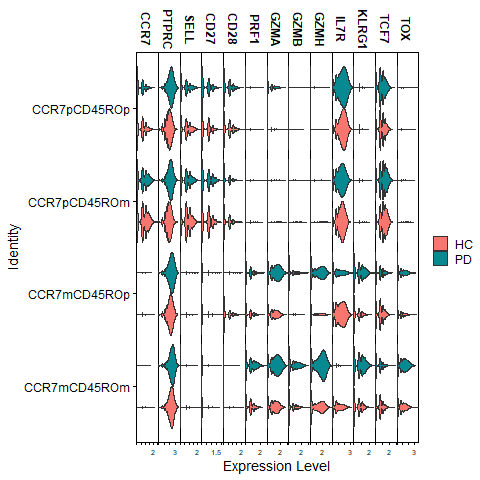

In [8]:
%%R
DefaultAssay(SCT.combined) <- "SCT"
SCT.combined <- SetIdent(SCT.combined , value = "CellType")
VlnPlot(SCT.combined , features = c("CCR7","PTPRC", "SELL", "CD27", "CD28", "PRF1", "GZMA", "GZMB", "GZMH", "IL7R", "KLRG1", "TCF7", "TOX"),stack=T, split.by = "Condition",pt.size=0)

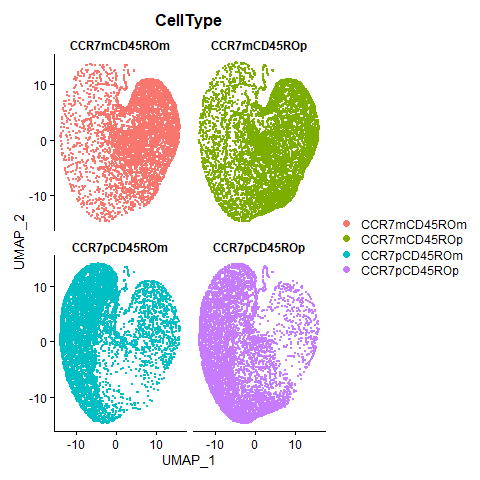

In [60]:
%%R
DefaultAssay(SCT.combined) <- "integrated"
SCT.combined <- RunPCA(SCT.combined, verbose = FALSE,features= c("CCR7","PTPRC", "SELL", "CD27", "CD28", "PRF1", "GZMA", "GZMB", "GZMH", "IL7R", "KLRG1", "TCF7", "TOX"))
SCT.combined <- RunUMAP(SCT.combined, reduction = "pca", dims = 1:3)
DimPlot(SCT.combined , reduction = "umap", group.by = "CellType",split.by="CellType",ncol=2)

In [61]:
%%R
SCT.combined <- FindNeighbors(SCT.combined, reduction = "pca", dims = 1:5)
SCT.combined <- FindClusters(SCT.combined, resolution = 0.2)
SCT.combined$sl_feat_cl <- SCT.combined$integrated_snn_res.0.2

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34792
Number of edges: 964937

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9399
Number of communities: 9
Elapsed time: 3 seconds


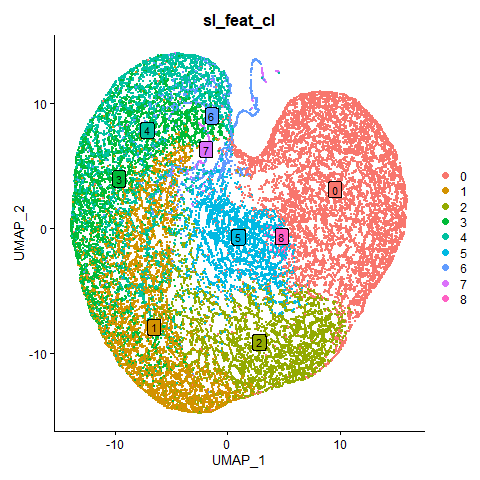

In [62]:
%%R
DimPlot(SCT.combined , reduction = "umap", group.by = "sl_feat_cl",label=T,label.box=T)

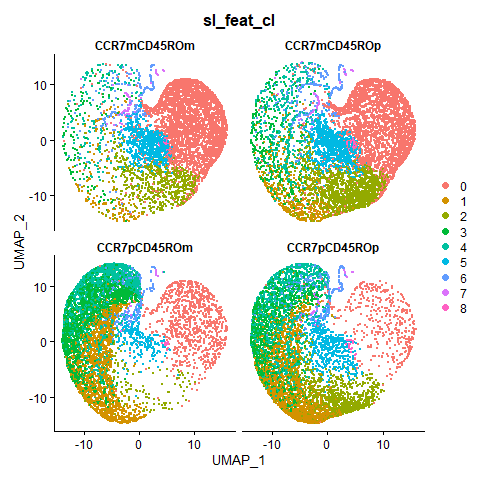

In [63]:
%%R
DimPlot(SCT.combined , reduction = "umap", group.by = "sl_feat_cl",split.by="CellType",ncol=2)

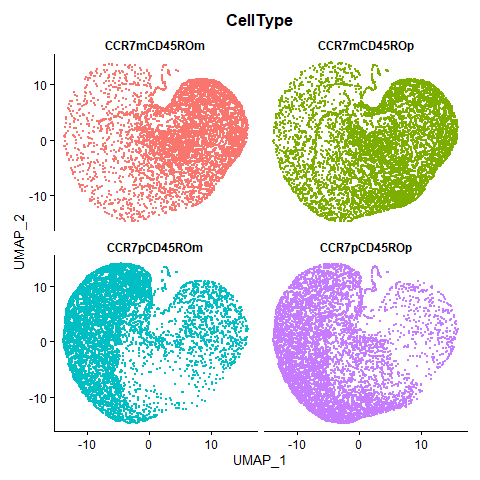

In [64]:
%%R
DimPlot(SCT.combined , reduction = "umap", group.by = "CellType",split.by="CellType",ncol=2)+NoLegend()

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is

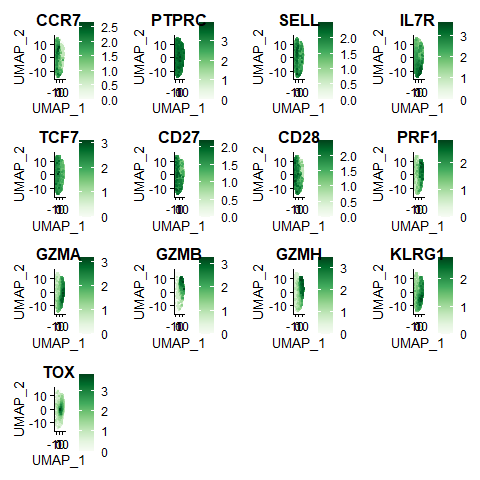

In [67]:
%%R -i resultdir
library(RColorBrewer)
DefaultAssay(SCT.combined) <- "SCT"

pfeat <- FeaturePlot(SCT.combined, features=c("CCR7","PTPRC", "SELL","IL7R","TCF7", "CD27", "CD28", "PRF1", "GZMA", "GZMB", "GZMH",  "KLRG1",  "TOX"),order=T,ncol=4) &
    scale_colour_gradientn(colours =brewer.pal(n = 11, name = "Greens"))
    
ggsave(plot=pfeat,filename=paste0(resultdir,"Featureplot_SlFeatUMAP.png"),width=12,height=12)
pfeat

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


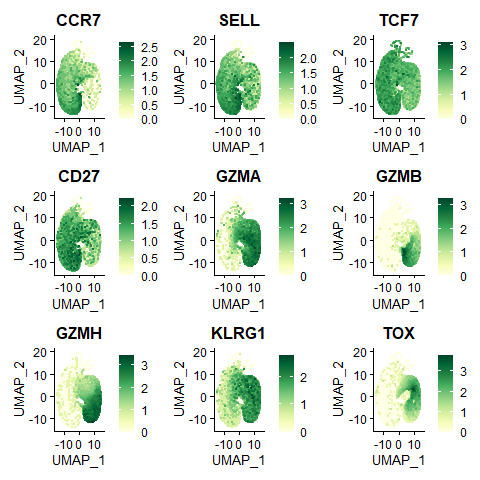

In [59]:
%%R
FeaturePlot(SCT.combined , features=c("CCR7","SELL","TCF7", "CD27", "GZMA", "GZMB", "GZMH",  "KLRG1",  "TOX"),order=T,ncol=3) &
    scale_colour_gradientn(colours =brewer.pal(n = 11, name = "YlGn"))

## Average Differential Expression

In [52]:
%%R
library(dplyr)
markers_df <- FindAllMarkers(SCT.combined,group.by="sct_int_clusters", only.pos = T,
    min.pct = 0.1, logfc.threshold = 0.5)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 3 % ~05s           |+++                                               | 4 % ~04s           |+++                                               | 6 % ~04s           |++++                                              | 7 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 16% ~04s           |+++++++++                                         | 18% ~04s           |++++++++++                                        | 19% ~04s 

In [53]:
%%R
markers_df  <- markers_df  %>% mutate(enrichment.ratio = pct.1 / (pct.2 + .000001),
                diff.pct = pct.1 - pct.2,
                gene.score = avg_log2FC * enrichment.ratio)
markers_df  <- markers_df  %>% 
    dplyr::select(gene, cluster, gene.score, p_val_adj, diff.pct, enrichment.ratio,
                    pct.1, pct.2, avg_log2FC) %>%
        mutate(across(where(is.numeric), .f = ~ round(.x, 5)))
markers_df  <- markers_df  %>% group_by(cluster) %>%
            arrange(desc(gene.score), .by_group = TRUE)

In [62]:
%%R -i resultdir
top10_gs <- markers_df %>%
    group_by(cluster) %>%
    top_n(n = 2, wt = gene.score)
top10_gs
readr::write_tsv(markers_df,paste0(resultdir,"df_cl.csv"))

top10_fc <- markers_df %>%
    group_by(cluster) %>%
    top_n(n = 2, wt = avg_log2FC)


In [55]:
%%R 
unique(SCT.combined$Combined)

 [1] "5_HC"  "7_HC"  "2_HC"  "3_HC"  "6_HC"  "0_HC"  "8_HC"  "4_HC"  "1_HC" 
[10] "10_HC" "11_HC" "12_HC" "9_HC"  "4_PD"  "7_PD"  "3_PD"  "2_PD"  "8_PD" 
[19] "10_PD" "5_PD"  "6_PD"  "11_PD" "0_PD"  "1_PD"  "9_PD"  "12_PD"


In [56]:
%%R -i resultdir
library(dittoSeq)
SCT.combined$Combined <- paste0(SCT.combined$sct_int_clusters,"_",SCT.combined$Condition)
avg_SCT_cl <- AverageExpression(SCT.combined,group.by="Combined",return.seurat = T)

In [58]:
%%R
library(stringr)
avg_SCT_cl$Cluster <- unlist(lapply(colnames(avg_SCT_cl),function(x){str_split(x,pattern="_")[[1]][1]}))
avg_SCT_cl$Cluster <- factor(avg_SCT_cl$Cluster,levels=c(0:20))
avg_SCT_cl$Condition <- unlist(lapply(colnames(avg_SCT_cl),function(x){str_split(x,pattern="_")[[1]][2]}))


In [74]:
%%R -i resultdir
dittoHeatmap(avg_SCT_cl,unique(top10_gs$gene),
    annot.by = c("Cluster","Condition"),cluster_cols=T,filename=paste0(resultdir,"Heatmap_cl_hierarchical.png"),width=15)

In [75]:
%%R
dittoHeatmap(avg_SCT_cl,unique(top10$gene),
    annot.by = c("Cluster","Condition"),cluster_cols=F,filename=paste0(resultdir,"Heatmap_cl.png"),width=15)

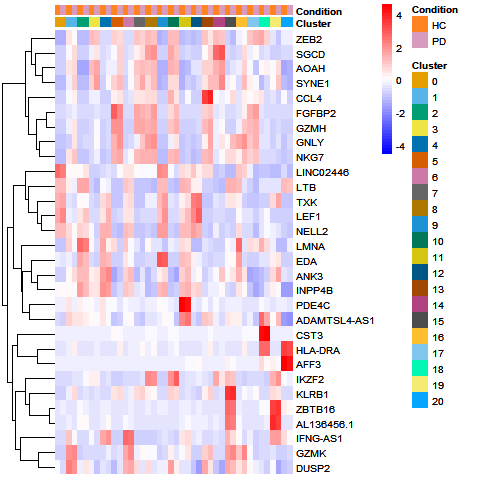

In [65]:
%%R
dittoHeatmap(avg_SCT_cl,unique(top10_fc$gene),
    annot.by = c("Cluster","Condition"),cluster_cols=F)#+ggsave(paste0(resultdir,"Heatmap_cl.png"))

## CCR7mCD45ROp

In [116]:
%%R
CCR7mCD45ROp = subset(SCT.combined, subset= CellType =="CCR7mCD45ROp")
CCR7mCD45ROp<- SetIdent(CCR7mCD45ROp , value = "Condition")
CCR7mCD45ROp <- PrepSCTFindMarkers(CCR7mCD45ROp)
DE_CCR7mCD45ROp <-  FindMarkers(CCR7mCD45ROp,ident.1="HC",ident.2="PD",
    min.pct = 0.5,
    logfc.threshold = 0)

Exception ignored from cffi callback <function _callback at 0x000002C38A8E8790>:
Traceback (most recent call last):
  File "c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 330, in _callback
    callback()
  File "c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 319, in callback
    def callback() -> None:
KeyboardInterrupt: 


  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~33s           |++                                                | 2 % ~30s           |++                                                | 3 % ~29s           |+++                                               | 4 % ~28s           |+++                                               | 5 % ~27s           |++++                                              | 7 % ~27s           |++++                                              | 8 % ~26s           |+++++                                             | 9 % ~26s           |+++++                                             | 10% ~25s           |++++++                                            | 11% ~25s           |++++++                                            | 12% ~25s           |+++++++                                           | 13% ~24s           |++++++++                                          | 14% ~24s 

Exception ignored from cffi callback <function _callback at 0x000002C38A8E8790>:
Traceback (most recent call last):
  File "c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 330, in _callback
    callback()
  File "c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 319, in callback
    def callback() -> None:
KeyboardInterrupt: 


  |+++++++++                                         | 16% ~40s           |+++++++++                                         | 17% ~38s           |++++++++++                                        | 18% ~37s           |++++++++++                                        | 20% ~36s           |+++++++++++                                       | 21% ~36s           |+++++++++++                                       | 22% ~35s           |++++++++++++                                      | 23% ~35s           |++++++++++++                                      | 24% ~34s           |+++++++++++++                                     | 25% ~34s           |++++++++++++++                                    | 26% ~33s           |++++++++++++++                                    | 27% ~32s           |+++++++++++++++                                   | 28% ~31s           |+++++++++++++++                                   | 29% ~30s           |++++++++++++++++                                  | 30% ~30s 

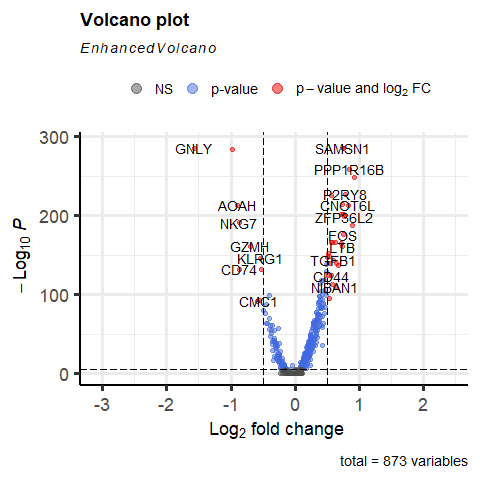

In [74]:
%%R
EnhancedVolcano(DE_CCR7mCD45ROp,
    lab = rownames(DE_CCR7mCD45ROp),
    x = 'avg_log2FC',
    y = 'p_val_adj',FCcutoff = 0.5)

## CCR7pCD45ROm

In [75]:
%%R
CCR7pCD45ROm = subset(SCT.combined, subset= CellType =="CCR7pCD45ROm")
CCR7pCD45ROm<- SetIdent(CCR7pCD45ROm , value = "Condition")
CCR7pCD45ROm <- PrepSCTFindMarkers(CCR7pCD45ROm)
DE_CCR7pCD45ROm <-  FindMarkers(CCR7pCD45ROm,ident.1="HC",ident.2="PD",
    min.pct = 0.5,
    logfc.threshold = 0)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~28s           |++                                                | 2 % ~28s           |++                                                | 3 % ~28s           |+++                                               | 4 % ~28s           |+++                                               | 5 % ~28s           |++++                                              | 6 % ~28s           |++++                                              | 7 % ~27s           |+++++                                             | 8 % ~27s           |+++++                                             | 9 % ~27s           |++++++                                            | 11% ~26s           |++++++                                            | 12% ~26s           |+++++++                                           | 13% ~25s           |+++++++                                           | 14% ~25s 

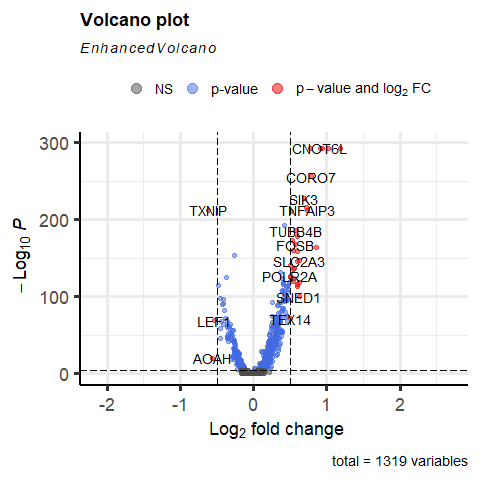

In [76]:
%%R
EnhancedVolcano(DE_CCR7pCD45ROm,
    lab = rownames(DE_CCR7pCD45ROm),
    x = 'avg_log2FC',
    y = 'p_val_adj',FCcutoff = 0.5)

## CCR7pCD45ROp

In [77]:
%%R
library(DESeq2)
CCR7pCD45ROp = subset(SCT.combined, subset= CellType =="CCR7pCD45ROp")
CCR7pCD45ROp<- SetIdent(CCR7pCD45ROp , value = "Condition")
CCR7pCD45ROp <- PrepSCTFindMarkers(CCR7pCD45ROp)


In [78]:
%%R
DE_CCR7pCD45ROp <-  FindMarkers(CCR7pCD45ROp,ident.1="HC",ident.2="PD",
    min.pct = 0.5,
    logfc.threshold = 0)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~21s           |++                                                | 2 % ~21s           |++                                                | 3 % ~21s           |+++                                               | 4 % ~20s           |+++                                               | 5 % ~20s           |++++                                              | 6 % ~20s           |++++                                              | 7 % ~19s           |+++++                                             | 8 % ~19s           |+++++                                             | 9 % ~19s           |++++++                                            | 10% ~19s           |++++++                                            | 11% ~19s           |+++++++                                           | 12% ~18s           |+++++++                                           | 13% ~18s 

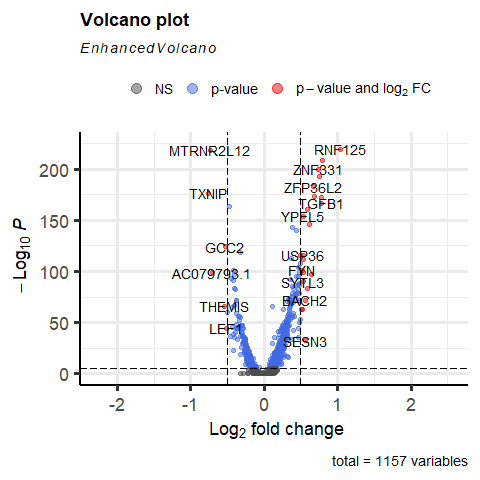

In [79]:
%%R
library(EnhancedVolcano)
EnhancedVolcano(DE_CCR7pCD45ROp,
    lab = rownames(DE_CCR7pCD45ROp),
    x = 'avg_log2FC',
    y = 'p_val_adj',FCcutoff = 0.5)

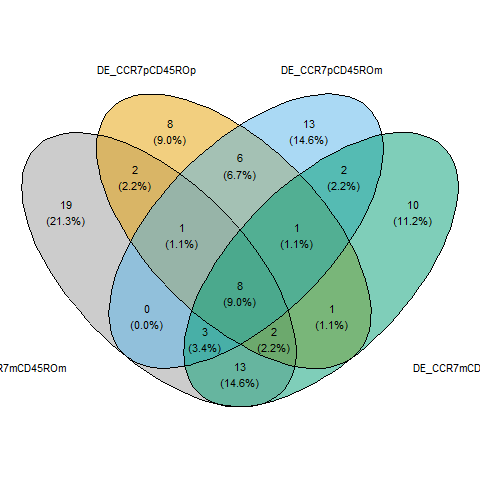

In [80]:
%%R
library(ggvenn)
x <- list( 
    DE_CCR7mCD45ROm = rownames(DE_CCR7mCD45ROm %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    DE_CCR7pCD45ROp = rownames(DE_CCR7pCD45ROp %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    DE_CCR7pCD45ROm = rownames(DE_CCR7pCD45ROm %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    DE_CCR7mCD45ROp = rownames(DE_CCR7mCD45ROp %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05))
)
ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )


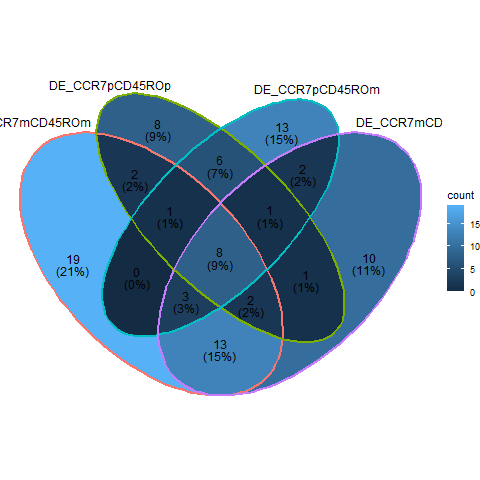

In [103]:
%%R
library("ggVennDiagram")
ggVennDiagram(x, label_alpha = 0)

In [81]:
%%R
Allcommon <- Reduce(intersect,x)
Allcommon


[1] "CNOT6L"  "P2RY8"   "ZNF331"  "RNF125"  "ZFP36L2" "BORCS5"  "BACH2"  
[8] "TNFAIP3"


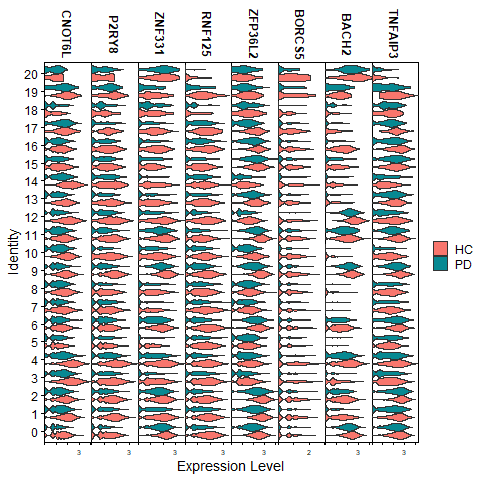

In [82]:
%%R
VlnPlot(SCT.combined, Allcommon,stack=T,split.by="Condition")

In [83]:
%%R
library(enrichR)
dbs <- listEnrichrDbs()

In [67]:
%%R
colnames(dbs)

[1] "geneCoverage" "genesPerTerm" "libraryName"  "link"         "numTerms"    
[6] "appyter"      "categoryId"  


In [84]:
%%R
list_2021 <- as.vector(grep("2021",unique(dbs$libraryName)))

list_2022 <- as.vector(grep("2022",unique(dbs$libraryName)))

list_parkinson <- as.vector(grep("Parki",unique(dbs$libraryName)))

list_2021
dbs$libraryName[list_2021]

 [1] "Allen_Brain_Atlas_10x_scRNA_2021"    
 [2] "Descartes_Cell_Types_and_Tissue_2021"
 [3] "KEGG_2021_Human"                     
 [4] "WikiPathway_2021_Human"              
 [5] "GO_Biological_Process_2021"          
 [6] "GO_Cellular_Component_2021"          
 [7] "GO_Molecular_Function_2021"          
 [8] "MGI_Mammalian_Phenotype_Level_4_2021"
 [9] "CellMarker_Augmented_2021"           
[10] "Orphanet_Augmented_2021"             
[11] "COVID-19_Related_Gene_Sets_2021"     
[12] "PanglaoDB_Augmented_2021"            
[13] "Azimuth_Cell_Types_2021"             
[14] "PhenGenI_Association_2021"           
[15] "GTEx_Aging_Signatures_2021"          
[16] "HDSigDB_Human_2021"                  
[17] "HDSigDB_Mouse_2021"                  


## GO_Biological_Process_2021

In [114]:
%%R -i resultdir
obj_list_celltype = list(
    "CCR7mCD45ROm" = CCR7mCD45ROm,
    "CCR7pCD45ROp" = CCR7pCD45ROp,
    "CCR7mCD45ROp" = CCR7mCD45ROp,
    "CCR7pCD45ROm" = CCR7pCD45ROm
)

list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="GO_Biological_Process_2021", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_GO_Biological_Process_2021_",celltype_name,".png"),width=15,height=12)
    plot_enrich
})


[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 2 % ~03s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 8 % ~03s           |+++++                                             | 9 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |+++++++                                           | 14% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                 

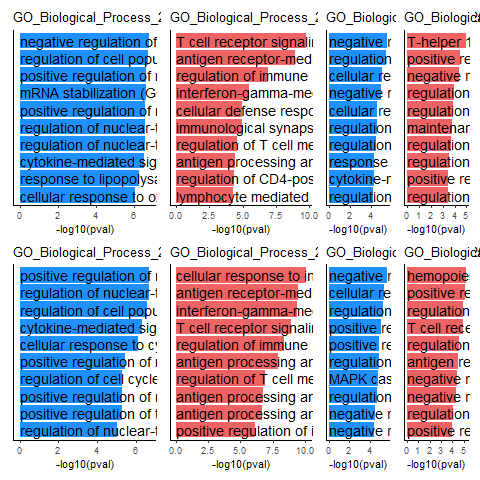

In [117]:
%%R
library(patchwork)
# list_plot_enrich[1]
(list_plot_enrich[[1]]+list_plot_enrich[[2]]) / (list_plot_enrich[[3]]+list_plot_enrich[[4]])

## Reactome_2022

In [118]:
%%R -i resultdir
Reactome_2022_list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="Reactome_2022", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_Reactome_2022_",celltype_name,".png"),width=15,height=12)
    plot_enrich
})

[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~03s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 8 % ~03s           |+++++                                             | 9 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |+++++++                                           | 14% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                 

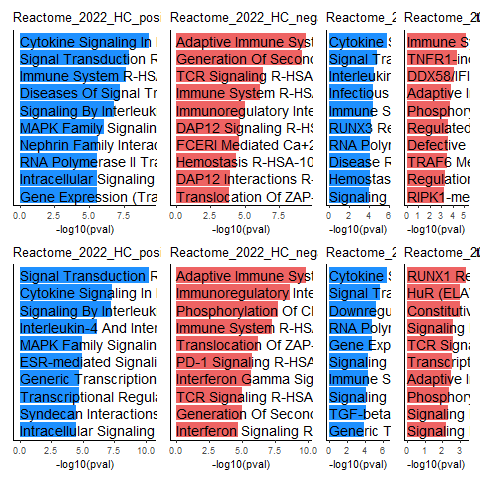

In [119]:
%%R
(Reactome_2022_list_plot_enrich[[1]]+Reactome_2022_list_plot_enrich[[2]]) / 
(Reactome_2022_list_plot_enrich[[3]]+Reactome_2022_list_plot_enrich[[4]])

## KEGG_2021_Human

In [123]:
%%R -i resultdir
KEGG_2021_Human_list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="KEGG_2021_Human", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_KEGG_2021_Human_",celltype_name,".png"))
    plot_enrich
})



[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~03s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 8 % ~03s           |+++++                                             | 9 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |+++++++                                           | 14% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                 

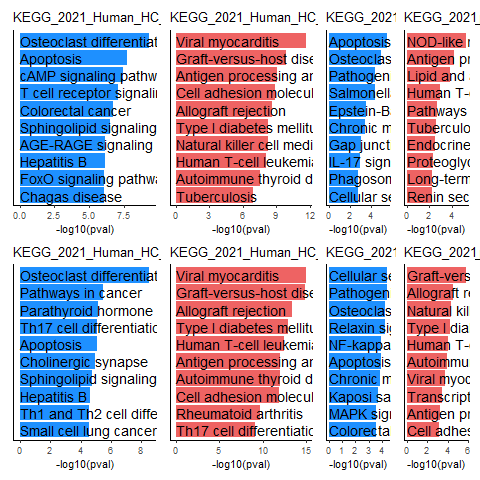

In [122]:
%%R
(KEGG_2021_Human_list_plot_enrich[[1]]+KEGG_2021_Human_list_plot_enrich[[2]]) / 
(KEGG_2021_Human_list_plot_enrich[[3]]+KEGG_2021_Human_list_plot_enrich[[4]])

## WikiPathway_2021_Human

In [124]:
%%R -i resultdir
WikiPathway_2021_Human_list_plot_enrich <- lapply(1:length(obj_list_celltype),FUN=function(x){
    celltype_name = names(obj_list_celltype)[x]
    celltype_obj = obj_list_celltype[[celltype_name]]
    print(celltype_name)
    plot_enrich <- DEenrichRPlot(
        celltype_obj,
        ident.1 = "HC",
        ident.2 = "PD",
        balanced = TRUE,
        enrich.database="WikiPathway_2021_Human", 
        logfc.threshold = 0.25,
        max.genes=500,
        test.use = "wilcox",
        p.val.cutoff = 0.05,
        num.pathway = 10)
    ggsave(plot=plot_enrich,
        filename=paste0(resultdir,"Res_WikiPathway_2021_Human_",celltype_name,".png"))
    plot_enrich
})


[1] "CCR7mCD45ROm"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 2 % ~03s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 8 % ~03s           |+++++                                             | 9 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |+++++++                                           | 14% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                 

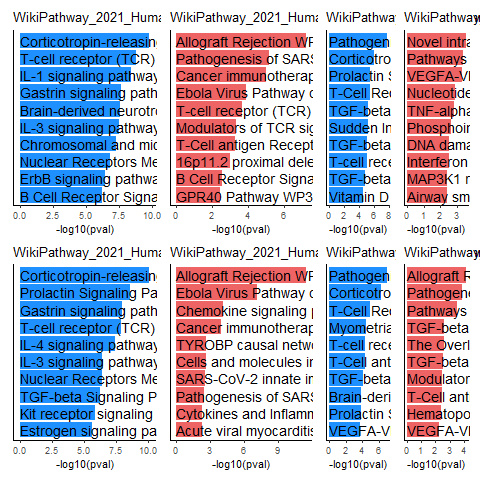

In [125]:
%%R
(WikiPathway_2021_Human_list_plot_enrich[[1]]+WikiPathway_2021_Human_list_plot_enrich[[2]]) / 
(WikiPathway_2021_Human_list_plot_enrich[[3]]+WikiPathway_2021_Human_list_plot_enrich[[4]])

## LIGER

In [127]:
%%R
DefaultAssay(SCT.combined ) <- "RNA"
SCT.combined  <- NormalizeData(SCT.combined )
SCT.combined  <- FindVariableFeatures(SCT.combined )
SCT.combined  <- ScaleData(SCT.combined , split.by = "Condition", do.center = FALSE)
SCT.combined  <- RunOptimizeALS(SCT.combined ,assay = "RNA", k = 20, lambda = 5, split.by = "Condition")
SCT.combined  <- RunQuantileNorm(SCT.combined , split.by = "Condition")
# You can optionally perform Louvain clustering (`FindNeighbors` and `FindClusters`) after
# `RunQuantileNorm` according to your needs
SCT.combined  <- FindNeighbors(SCT.combined , reduction = "iNMF", dims = 1:20)
SCT.combined  <- FindClusters(SCT.combined , resolution = 0.3)
SCT.combined $liger_clusters <- SCT.combined $RNA_snn_res.0.3
# Dimensional reduction and plotting
SCT.combined  <- RunUMAP(SCT.combined , dims = 1:ncol(SCT.combined [["iNMF"]]),
    reduction = "iNMF",
    reduction.name = "liger_umap",
    reduction.key = "UMAP_")

  |======================================================================| 100%
Finished in 7.593731 mins, 30 iterations.
Max iterations set: 30.
Final objective delta: 1.504162e-05.
Best results with seed 1.
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34792
Number of edges: 1049158

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9125
Number of communities: 10
Elapsed time: 11 seconds


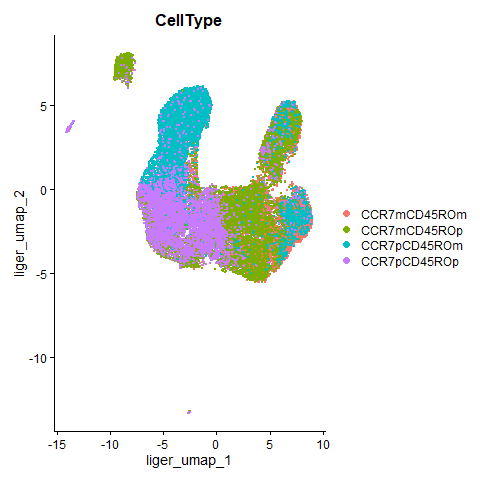

In [128]:
%%R
DimPlot(SCT.combined ,group.by="CellType", reduction = "liger_umap", pt.size=0.0001)

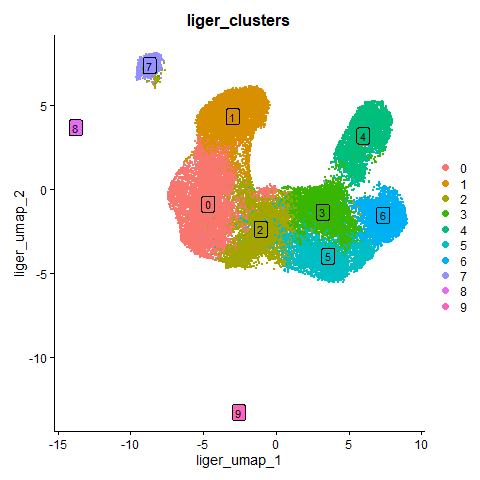

In [132]:
%%R
DimPlot(SCT.combined ,group.by="liger_clusters", reduction = "liger_umap", pt.size=0.0001,label=T,label.box=T)

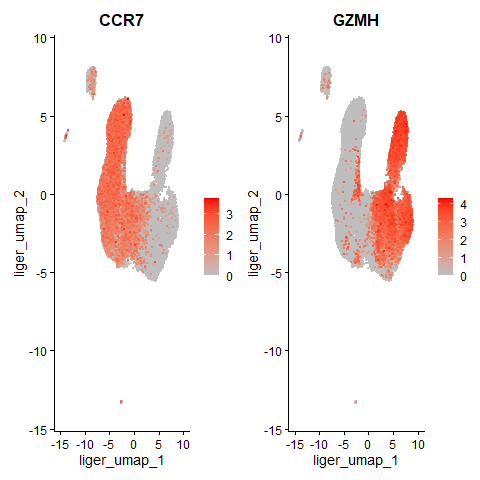

In [130]:
%%R
FeaturePlot(SCT.combined , reduction = "liger_umap", 
    features = c("CCR7","GZMH"), 
    max.cutoff = 5,order=T,
    cols = c("grey", "red"))

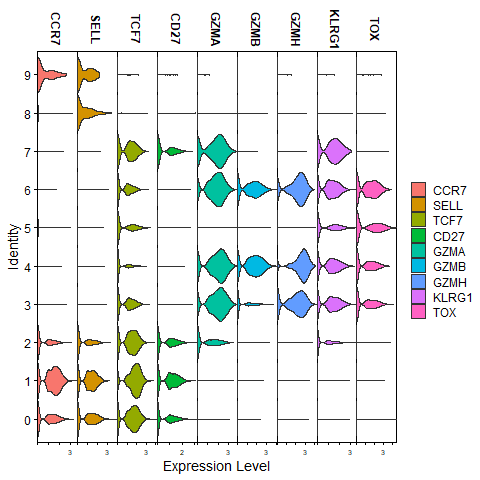

In [131]:
%%R
VlnPlot(SCT.combined,group.by="liger_clusters" , features=c("CCR7","SELL","TCF7", "CD27", "GZMA", "GZMB", "GZMH",  "KLRG1",  "TOX"),stack=T)

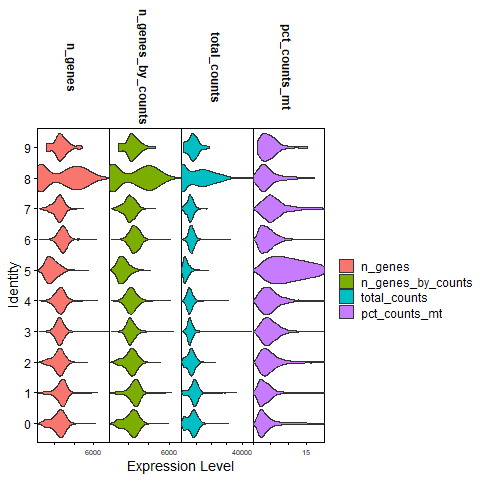

In [136]:
%%R
VlnPlot(SCT.combined,group.by="liger_clusters" , features=c("n_genes","n_genes_by_counts","total_counts", "pct_counts_mt"),stack=T)

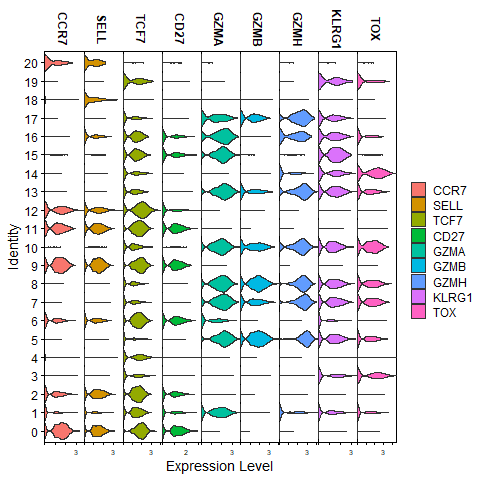

In [133]:
%%R
VlnPlot(SCT.combined,group.by="sct_int_clusters" , features=c("CCR7","SELL","TCF7", "CD27", "GZMA", "GZMB", "GZMH",  "KLRG1",  "TOX"),stack=T)

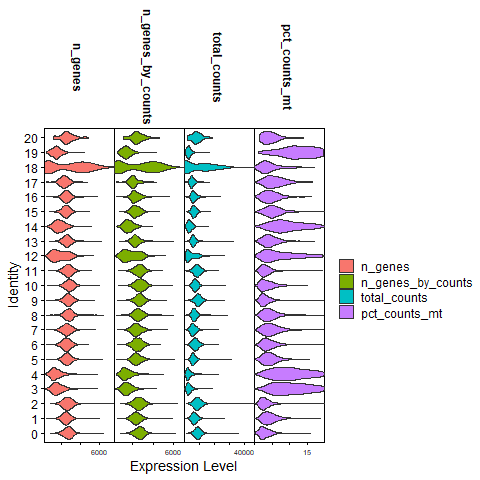

In [135]:
%%R
VlnPlot(SCT.combined,group.by="sct_int_clusters" , features=c("n_genes","n_genes_by_counts","total_counts", "pct_counts_mt"),stack=T)

In [134]:
%%R
colnames(SCT.combined@meta.data)

 [1] "orig.ident"                 "nCount_RNA"                
 [3] "nFeature_RNA"               "n_genes"                   
 [5] "scDblFinder_class"          "n_genes_by_counts"         
 [7] "log1p_n_genes_by_counts"    "total_counts"              
 [9] "log1p_total_counts"         "pct_counts_in_top_20_genes"
[11] "Condition"                  "CellType"                  
[13] "batch"                      "total_counts_mt"           
[15] "log1p_total_counts_mt"      "pct_counts_mt"             
[17] "total_counts_ribo"          "log1p_total_counts_ribo"   
[19] "pct_counts_ribo"            "total_counts_hb"           
[21] "log1p_total_counts_hb"      "pct_counts_hb"             
[23] "mt_outlier"                 "leiden"                    
[25] "louvain"                    "mito_leiden"               
[27] "RNA_snn_res.0.5"            "seurat_clusters"           
[29] "sct_clusters"               "nCount_SCT"                
[31] "nFeature_SCT"               "integrated_snn_res.0